# 📌 Project: End-to-End Customer Behavior Analysis and Prediction

 - In this project, we analyze eCommerce behavioral data to understand customer purchase patterns,
 - apply RFM (Recency, Frequency, Monetary) segmentation, and build a predictive model for purchases.


In [ ]:
# ! pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap 

## 1. 🛠️ Library Imports

In [ ]:
# Standard Library
import os
import json
import warnings
from datetime import datetime

# Data Handling
import duckdb
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Progress Display
from tqdm import tqdm

# Machine Learning - Scikit-Learn
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn import preprocessing 
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    brier_score_loss, # for calibration
    precision_score,
    roc_auc_score,
    recall_score,
    roc_curve,
    auc
)

# Machine Learning - External
from sklearn.cluster import KMeans
import xgboost as xgb
import shap

# Model Persistence
import joblib

# Silence warnings
warnings.filterwarnings("ignore")


In [2]:
import gc
import logging
import memory_profiler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    precision_recall_curve, roc_curve, f1_score,
    classification_report, confusion_matrix
)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.calibration import calibration_curve
from typing import List, Tuple, Dict, Any, Optional, Union

# Helper type for data
DataType = Union[np.ndarray, pd.DataFrame, pd.Series]

import lightgbm as lgb # Import LightGBM here

from sklearn.datasets import make_classification
import inspect

In [3]:
# Configure visualization defaults
plt.style.use('seaborn-v0_8')  # Or another available seaborn style
sns.set_palette('husl')
pd.options.display.float_format = '{:,.2f}'.format
tqdm.pandas()

## 2. 📥 Data Loading & Initial Exploration

In [4]:
# file_path1 = r"D:\Learnings\My_Projects\Datasets\eCommerce behavior data 2019-Nov\eCommerce behavior data 2019-Nov.parquet"

# # Open the Parquet file
# parquet_file = pq.ParquetFile(file_path1)

# # Get total number of row groups (each can be treated as a chunk)
# num_row_groups = parquet_file.num_row_groups

# print(f"Total Row Groups: {num_row_groups}")

# # Read one chunk (row group) at a time
# for i in range(num_row_groups):
#     if i< 1:
#         df_chunk = parquet_file.read_row_group(i).to_pandas()
#         print(f"Chunk {i+1}/{num_row_groups} - Shape: {df_chunk.shape}")
    
# df_chunk.shape

#### Read all rows from the Parquet file using DuckDB — it's often faster and more memory-efficient than pandas

In [5]:
file_path = r"D:\Learnings\My_Projects\Datasets\eCommerce behavior data 2019-Nov\eCommerce behavior data 2019-Nov.parquet"
con = duckdb.connect()

# Step 1: Get list of columns to filter out NULLs
columns = con.execute(f"DESCRIBE SELECT * FROM '{file_path}'").fetchdf()['column_name'].tolist()
null_filter = " AND ".join([f"{col} IS NOT NULL" for col in columns])

# Step 2: Get top 10 most frequent category_code values
top_categories_query = f"""
    SELECT category_code
    FROM '{file_path}'
    WHERE category_code IS NOT NULL
    GROUP BY category_code
    ORDER BY COUNT(*) DESC
    LIMIT 10
"""
top_categories = con.execute(top_categories_query).fetchdf()['category_code'].tolist()

# Convert to SQL-safe IN clause
category_filter = ', '.join([f"'{cat}'" for cat in top_categories])

# Step 3: Final query with both filters
query = f"""
    SELECT *
    FROM '{file_path}'
    WHERE {null_filter}
      AND category_code IN ({category_filter})
    LIMIT 1000000
"""

df_clean = con.execute(query).fetchdf()

print(f"Filtered rows (no NULLs, top 10 categories): {df_clean.shape}")
df_clean['category_code'].value_counts().head(10)


Filtered rows (no NULLs, top 10 categories): (1000000, 9)


category_code
electronics.smartphone              559718
computers.notebook                   67326
electronics.video.tv                 67101
electronics.clocks                   58154
electronics.audio.headphone          54761
apparel.shoes                        46826
appliances.kitchen.washer            43256
appliances.environment.vacuum        42887
appliances.kitchen.refrigerators     36714
computers.desktop                    23257
Name: count, dtype: int64

In [6]:
df_clean.shape

(1000000, 9)

In [7]:
df_clean.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-02 16:18:07+05:30,view,28719690,2053013565748544479,apparel.shoes,betsy,44.76,551634462,30755b54-fae2-4875-aa02-b8d7483f1493
1,2019-11-02 16:18:08+05:30,view,1003317,2053013555631882655,electronics.smartphone,apple,928.18,559077183,df89a2bc-8758-4ec9-a104-8b4671ef8ed6


In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype                        
---  ------         --------------    -----                        
 0   event_time     1000000 non-null  datetime64[us, Asia/Calcutta]
 1   event_type     1000000 non-null  object                       
 2   product_id     1000000 non-null  int64                        
 3   category_id    1000000 non-null  int64                        
 4   category_code  1000000 non-null  object                       
 5   brand          1000000 non-null  object                       
 6   price          1000000 non-null  float64                      
 7   user_id        1000000 non-null  int64                        
 8   user_session   1000000 non-null  object                       
dtypes: datetime64[us, Asia/Calcutta](1), float64(1), int64(3), object(4)
memory usage: 68.7+ MB


In [9]:
df = df_clean
df.shape

(1000000, 9)

In [10]:
df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

## 🧹 3 Data Cleaning

In [11]:
# Drop rows with missing values
# df.dropna(inplace=True)

In [12]:
# Drop duplicates, keeping the last occurrence
df = df.drop_duplicates(keep = 'last')

In [13]:
df.shape

(999160, 9)

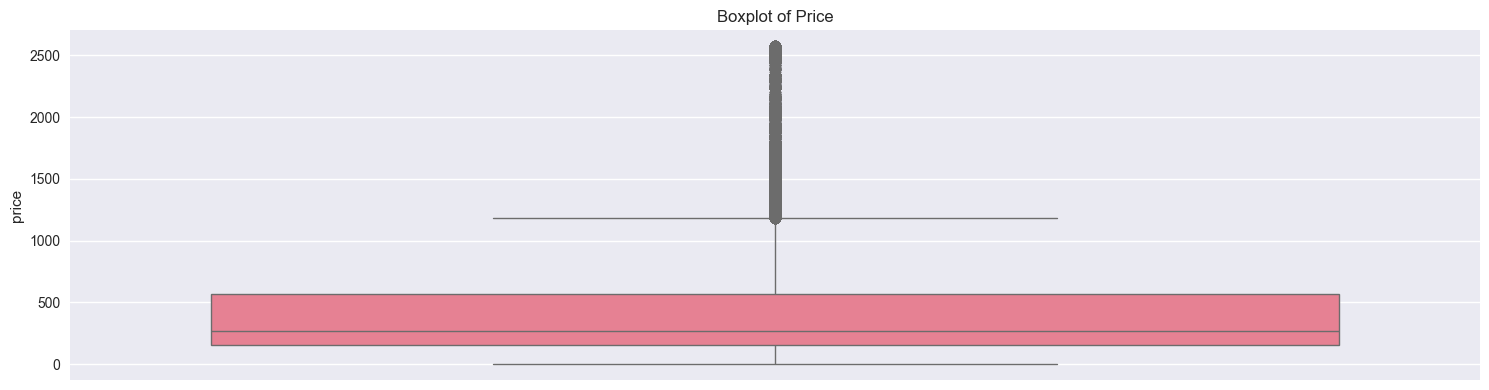

In [14]:
# Outlier Visualization using Box Plots

plt.figure(figsize=(15, 4))

sns.boxplot(y=df['price'])
plt.title('Boxplot of Price')

plt.tight_layout()
plt.show()

In [15]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Detect outliers for price features
outlier_price = detect_outliers_iqr(df, 'price')

print("Recency outliers:", len(outlier_price))


Recency outliers: 57641


In [16]:
df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-02 16:18:07+05:30,view,28719690,2053013565748544479,apparel.shoes,betsy,44.76,551634462,30755b54-fae2-4875-aa02-b8d7483f1493
1,2019-11-02 16:18:08+05:30,view,1003317,2053013555631882655,electronics.smartphone,apple,928.18,559077183,df89a2bc-8758-4ec9-a104-8b4671ef8ed6


## 🔍 4. Exploratory Data Analysis (EDA)

In [17]:
#### Feature Exploration & Engineering for Insights

# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Extract time-based features
df['hour'] = df['event_time'].dt.hour
df['day_of_week'] = df['event_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# Handle Categorical Data for Exploration
df['category_code'] = df['category_code'].fillna('unknown')
df[['main_category', 'sub_category']] = df['category_code'].str.split('.', n=1, expand=True)

In [18]:

unique_visitor = df['user_id'].nunique()
print ("Unique Visitors: {}".format(unique_visitor))

Unique Visitors: 202943


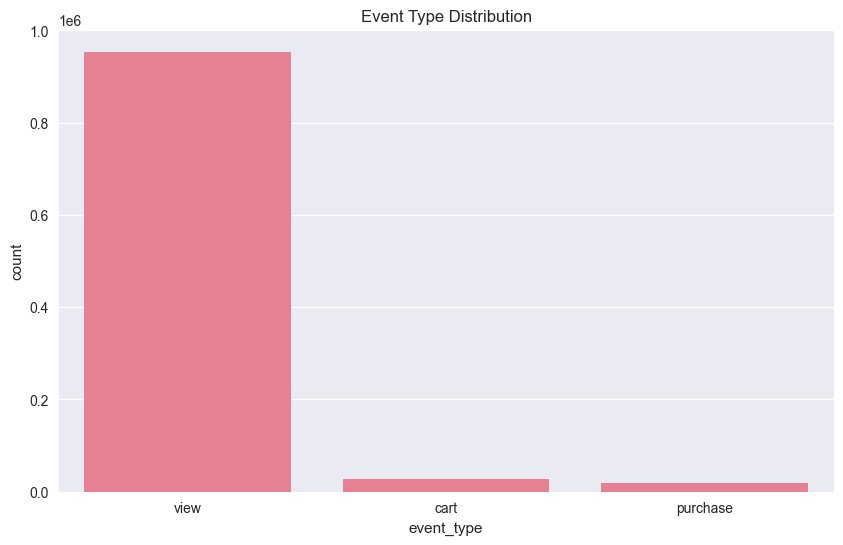

In [19]:
# Event type distribution
plt.figure(figsize=(10,6))
sns.countplot(x='event_type', data=df)
plt.title('Event Type Distribution')
plt.show()

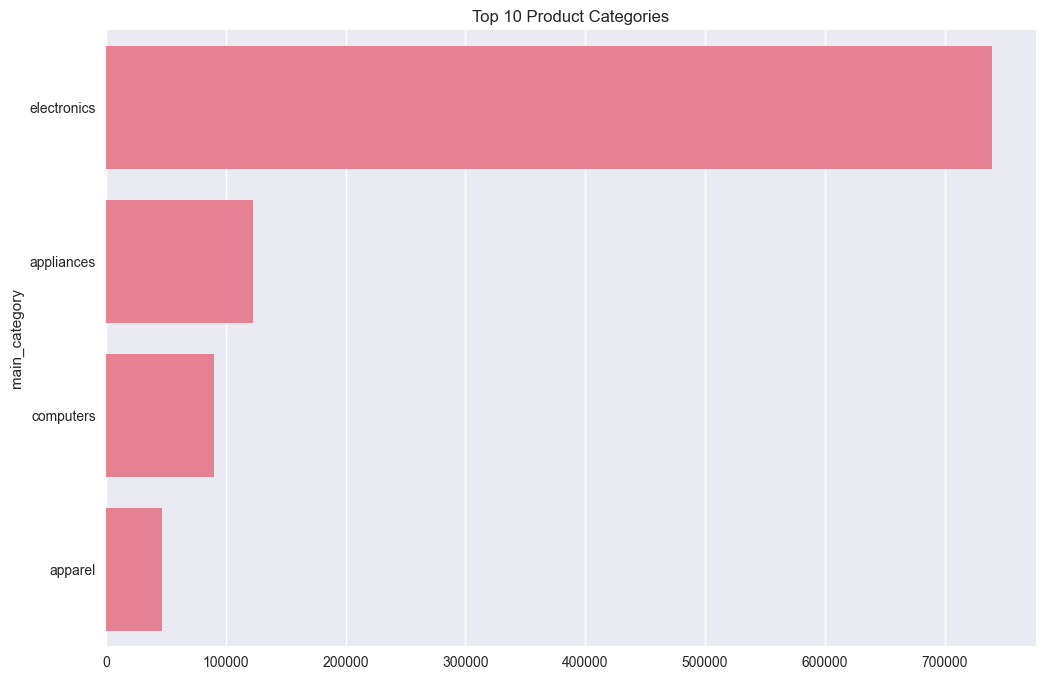

In [20]:
# Popular categories
top_categories = df['main_category'].value_counts().nlargest(10)
plt.figure(figsize=(12,8))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Product Categories')
plt.show()

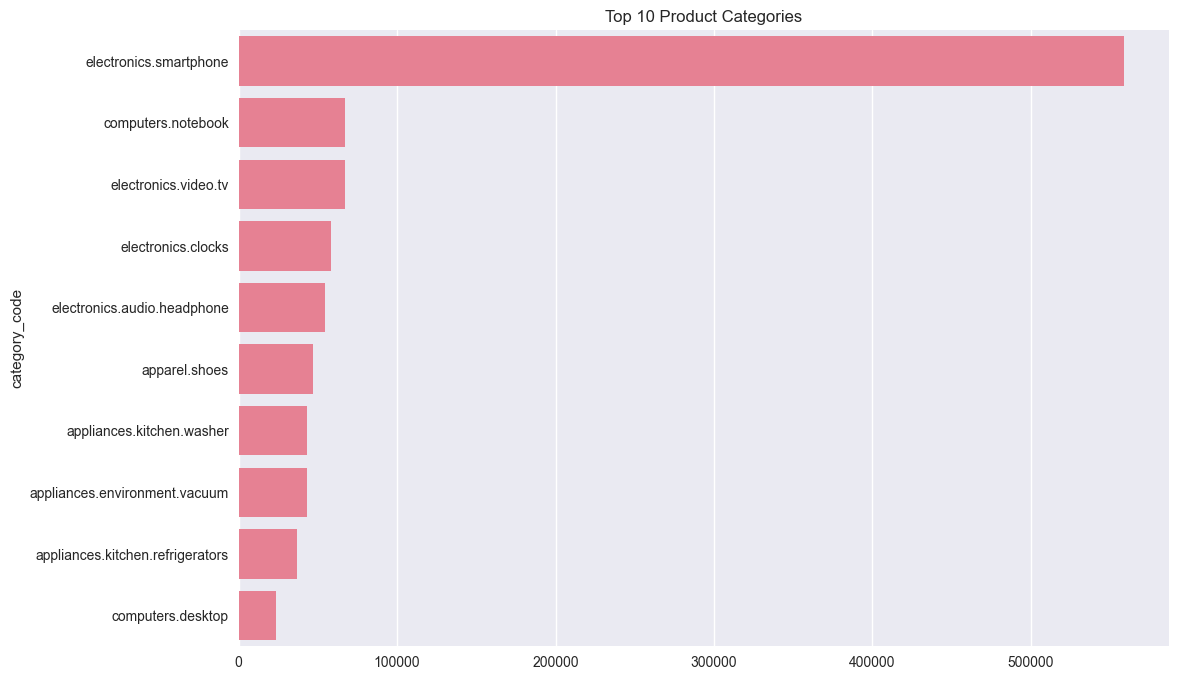

In [21]:
# Popular subcategory categories
top_categories = df['category_code'].value_counts().nlargest(10)
plt.figure(figsize=(12,8))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Product Categories')
plt.show()

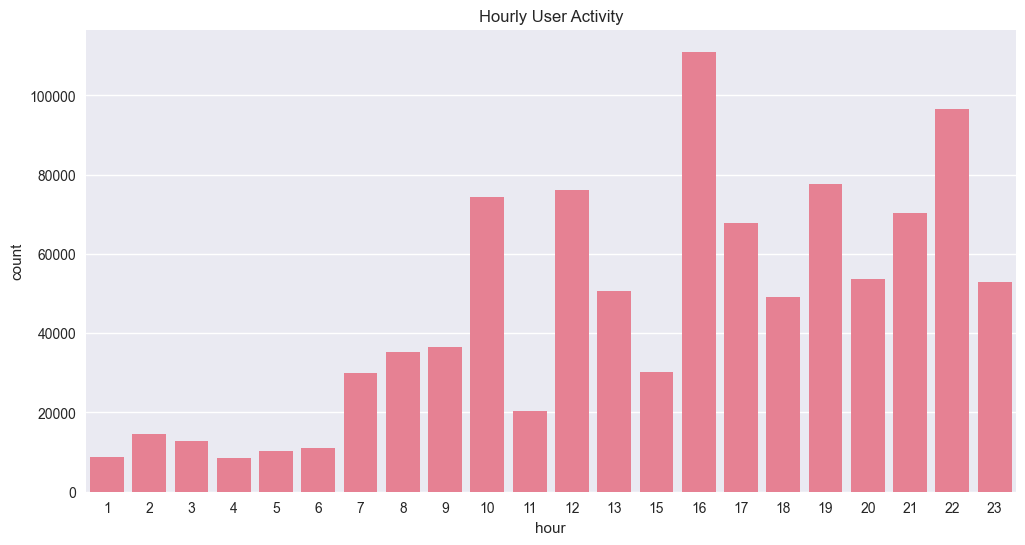

In [22]:
# User activity patterns
plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=df)
plt.title('Hourly User Activity')
plt.show()

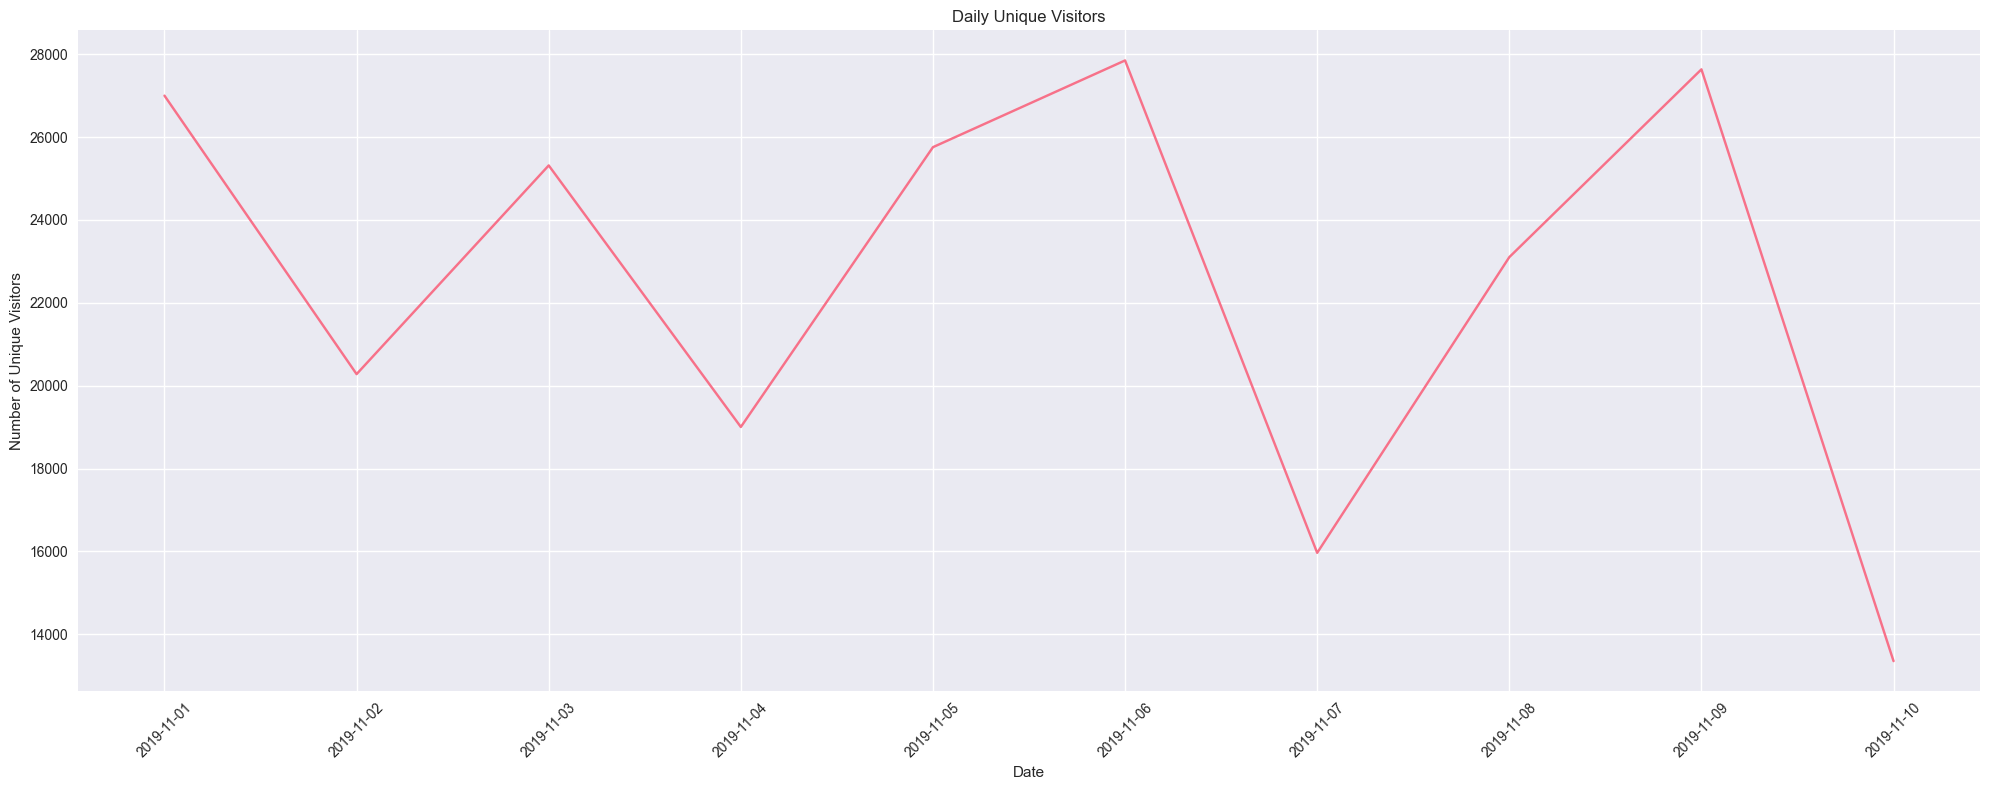

In [23]:
# Convert 'event_time' to datetime objects and extract the date
df['event_date'] = pd.to_datetime(df['event_time']).dt.date

# Count unique visitors per day
visitor_by_date = df.groupby('event_date')['user_id'].nunique().sort_index()

# Prepare data for plotting
dates = visitor_by_date.index
visitor_counts = visitor_by_date.values

# Set figure size
plt.rcParams['figure.figsize'] = (20, 8)

# Create the plot
plt.plot(dates, visitor_counts)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Unique Visitors')
plt.title('Daily Unique Visitors')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
df.shape

(999160, 15)

## 🧠 5. Feature Engineering

### 5.1 Feature Transformation and Creation

In [25]:
print("Shape: ", df.shape)
df.head(2)

Shape:  (999160, 15)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hour,day_of_week,is_weekend,main_category,sub_category,event_date
0,2019-11-02 16:18:07+05:30,view,28719690,2053013565748544479,apparel.shoes,betsy,44.76,551634462,30755b54-fae2-4875-aa02-b8d7483f1493,16,5,1,apparel,shoes,2019-11-02
1,2019-11-02 16:18:08+05:30,view,1003317,2053013555631882655,electronics.smartphone,apple,928.18,559077183,df89a2bc-8758-4ec9-a104-8b4671ef8ed6,16,5,1,electronics,smartphone,2019-11-02


In [26]:
## Feature Transformation

# Encoding Categorical Variables
df['category_code'] = df['category_code'].astype('category').cat.codes
df['brand'] = df['brand'].astype('category').cat.codes

df.shape

(999160, 15)

In [27]:
## Feature Creation

# User behavior features
user_stats = df.groupby('user_id').agg(
    total_clicks=('event_type', lambda x: (x == 'view').sum()),
    avg_session_time=('event_time', lambda x: x.diff().mean().total_seconds()),
    purchase_freq=('event_type', lambda x: (x == 'purchase').mean())
).reset_index()

In [28]:
user_stats.shape, df.shape

((202943, 4), (999160, 15))

In [29]:
df = df.merge(user_stats, on='user_id', how='left')
df.shape

(999160, 18)

In [30]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session', 'hour',
       'day_of_week', 'is_weekend', 'main_category', 'sub_category',
       'event_date', 'total_clicks', 'avg_session_time', 'purchase_freq'],
      dtype='object')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999160 entries, 0 to 999159
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype                        
---  ------            --------------   -----                        
 0   event_time        999160 non-null  datetime64[us, Asia/Calcutta]
 1   event_type        999160 non-null  object                       
 2   product_id        999160 non-null  int64                        
 3   category_id       999160 non-null  int64                        
 4   category_code     999160 non-null  int8                         
 5   brand             999160 non-null  int16                        
 6   price             999160 non-null  float64                      
 7   user_id           999160 non-null  int64                        
 8   user_session      999160 non-null  object                       
 9   hour              999160 non-null  int32                        
 10  day_of_week       999160 non-null  int32    

In [32]:
cols_to_drop = ['category_id', 'category_code', 'brand', 'day_of_week', 'sub_category', 'event_date' ]

In [33]:
df.drop(columns = cols_to_drop, inplace =True )
df.shape

(999160, 12)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999160 entries, 0 to 999159
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype                        
---  ------            --------------   -----                        
 0   event_time        999160 non-null  datetime64[us, Asia/Calcutta]
 1   event_type        999160 non-null  object                       
 2   product_id        999160 non-null  int64                        
 3   price             999160 non-null  float64                      
 4   user_id           999160 non-null  int64                        
 5   user_session      999160 non-null  object                       
 6   hour              999160 non-null  int32                        
 7   is_weekend        999160 non-null  int32                        
 8   main_category     999160 non-null  object                       
 9   total_clicks      999160 non-null  int64                        
 10  avg_session_time  937209 non-null  float64  

In [35]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'price', 'user_id',
       'user_session', 'hour', 'is_weekend', 'main_category', 'total_clicks',
       'avg_session_time', 'purchase_freq'],
      dtype='object')

In [36]:
# Session-level features
session_features = df.groupby('user_session').agg(
    session_start=('event_time', 'min'),
    session_end=('event_time', 'max'),
    products_viewed=('product_id', 'nunique'),
    price_range=('price', lambda x: x.max() - x.min())
).reset_index()

session_features['session_duration'] = (
    session_features['session_end'] - session_features['session_start']
).dt.total_seconds()

In [37]:
df = df.merge(session_features, on='user_session', how='left')

print("Shape: ", user_stats.shape)
user_stats.head(2)  

Shape:  (202943, 4)


,user_id,total_clicks,avg_session_time,purchase_freq
0,31198833,17,123.31,0.00
1,96041329,1,NaN,0.00


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999160 entries, 0 to 999159
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype                        
---  ------            --------------   -----                        
 0   event_time        999160 non-null  datetime64[us, Asia/Calcutta]
 1   event_type        999160 non-null  object                       
 2   product_id        999160 non-null  int64                        
 3   price             999160 non-null  float64                      
 4   user_id           999160 non-null  int64                        
 5   user_session      999160 non-null  object                       
 6   hour              999160 non-null  int32                        
 7   is_weekend        999160 non-null  int32                        
 8   main_category     999160 non-null  object                       
 9   total_clicks      999160 non-null  int64                        
 10  avg_session_time  937209 non-null  float64  

### 5.2 Customer Segmentation (RFM Analysis)

#### Customer Behavior Analysis (Exploratory/Descriptive)

**Goal:** Segment customers into behavior-based groups (e.g., loyal, dormant, high spenders).

Use:

 - uild dashboards or customer profiles.

 - Help marketers design targeted campaigns.

 - Understand lifecycle stages of customers.


#### RFM (Recency, Frequency, Monetary) analysis

The **mean of RFM analysis** refers to the **average values** of the three key metrics—**Recency**, **Frequency**, and **Monetary**—computed across all customers in your dataset. These averages help you understand the general behavior of your customer base.

Here's what each average tells you:

---

#### 📊 **1. Recency (R) – Mean**

* **Definition**: Average time since a customer’s last purchase.
* **Interpretation**:

  * A **lower** mean value means customers generally purchase **recently**.
  * A **higher** mean value suggests customers are **less active**.

---

#### 📊 **2. Frequency (F) – Mean**

* **Definition**: Average number of purchases in a given time period.
* **Interpretation**:

  * A **higher** mean value means customers **buy often**.
  * A **lower** mean means purchases are **infrequent**.

---

#### 📊 **3. Monetary (M) – Mean**

* **Definition**: Average amount spent by customers.
* **Interpretation**:

  * A **higher** mean value means customers **spend more**.
  * A **lower** mean suggests **lower revenue per customer**.

---

#### 🔢 Example (hypothetical)

| Metric    | Mean Value |
| --------- | ---------- |
| Recency   | 35 days    |
| Frequency | 4.2        |
| Monetary  | \$235.50   |

This would suggest that:

* On average, customers made their last purchase 35 days ago.
* They bought about 4 times.
* They spent around \$235 each.

---

You can calculate this in pandas like:

```python
rfm[['recency', 'frequency', 'monetary']].mean()
```

---

<br>

---

 - Performs customer segmentation analysis using RFM (Recency, Frequency, Monetary) analysis  and K-Means clustering. 

Overall Purpose:
To cluster customers based on their purchase behavior (how recently, frequently, and how much they buy), helping businesses:

 - Identify high-value customers

 - Target specific segments with tailored marketing

 - Improve customer retention strategies

In [39]:
# Calculate RFM metrics
current_date = df['event_time'].max() + pd.Timedelta(days=1)

rfm = df.groupby('user_id').agg({
    'event_time': lambda x: (current_date - x.max()).days,  # Recency
    'user_session': 'nunique',                              # Frequency
    'price': 'sum'                                          # Monetary
}).reset_index()

rfm.shape, rfm.columns

((202943, 4),
 Index(['user_id', 'event_time', 'user_session', 'price'], dtype='object'))

In [40]:
rfm.columns = ['user_id', 'recency', 'frequency', 'monetary']

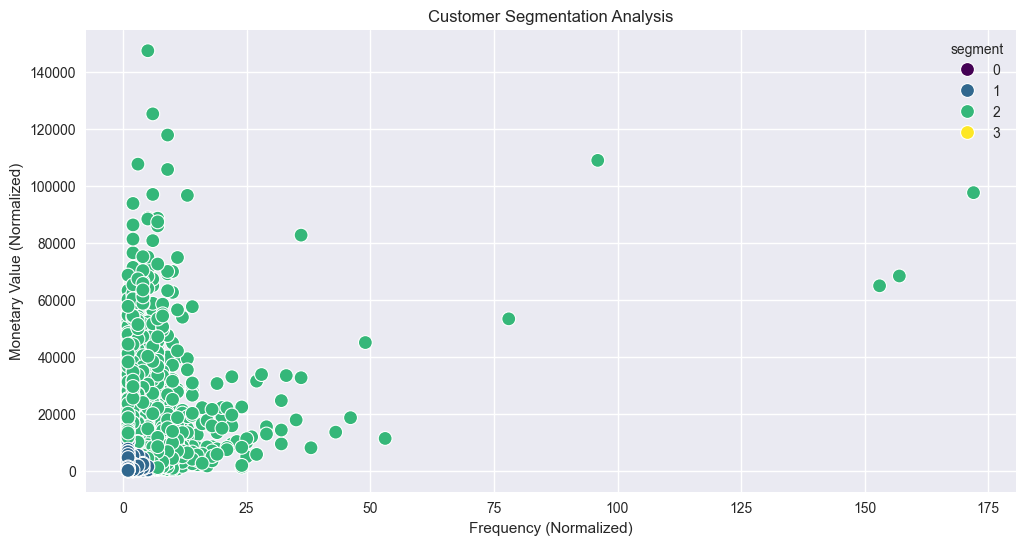

In [ ]:
# Normalize RFM values
scaler = preprocessing.StandardScaler()

rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']]),
    columns=['recency', 'frequency', 'monetary']
)

# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['segment'] = kmeans.fit_predict(rfm_scaled)

# Visualize segments
plt.figure(figsize=(12,6))
sns.scatterplot(x='frequency', y='monetary', hue='segment', 
                data=rfm, palette='viridis', s=100)
plt.title('Customer Segmentation Analysis')
plt.xlabel('Frequency (Normalized)')
plt.ylabel('Monetary Value (Normalized)')
plt.show()

## 6. Data Preparation for Modeling

In [42]:
df.shape, df.columns

((999160, 17),
 Index(['event_time', 'event_type', 'product_id', 'price', 'user_id',
        'user_session', 'hour', 'is_weekend', 'main_category', 'total_clicks',
        'avg_session_time', 'purchase_freq', 'session_start', 'session_end',
        'products_viewed', 'price_range', 'session_duration'],
       dtype='object'))

In [43]:
# Prepare modeling dataset
model_df = df[df['event_type'] == 'cart'].copy()
model_df['target'] = model_df['user_session'].isin(
    df[df['event_type'] == 'purchase']['user_session']
).astype(int)

model_df.shape

(26762, 18)

In [44]:
model_df.head(2)

,event_time,event_type,product_id,price,user_id,user_session,hour,is_weekend,main_category,total_clicks,avg_session_time,purchase_freq,session_start,session_end,products_viewed,price_range,session_duration,target
10,2019-11-02 16:18:09+05:30,cart,1004856,127.92,513785304,720a7eeb-3678-4840-889a-97e6961d4dca,16,1,electronics,3,12.00,0.00,2019-11-02 16:18:09+05:30,2019-11-02 16:18:45+05:30,2,11.16,36.00,0
39,2019-11-02 16:18:12+05:30,cart,5100566,453.14,517583033,4ee77a02-0cc6-4486-ae59-e42019bbb15d,16,1,electronics,3,"86,033.80",0.33,2019-11-02 16:18:12+05:30,2019-11-02 16:18:28+05:30,1,0.00,16.00,1


In [45]:
# # Feature selection
features = [
    'price', 'hour', 'is_weekend', 'total_clicks',
    'avg_session_time', 'purchase_freq', 'products_viewed',
    'price_range', 'session_duration', 'main_category'
]

# Feature selection with categorical/numeric split
categorical_features = ['main_category']
numerical_features = [
    'price', 'hour', 'is_weekend', 'total_clicks',
    'avg_session_time', 'purchase_freq', 'products_viewed',
    'price_range', 'session_duration'
]

In [46]:
X = model_df[features]
y = model_df['target']

# Split data into train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

In [47]:
X_train.columns

Index(['price', 'hour', 'is_weekend', 'total_clicks', 'avg_session_time',
       'purchase_freq', 'products_viewed', 'price_range', 'session_duration',
       'main_category'],
      dtype='object')

## 7. Model Development & Optimization

#### Machine learning pipeline for preprocessing and modeling using XGBoost.

Goal: Preprocess numerical and categorical features differently but in parallel.

How:

 - Scales numerical features (e.g., age, recency) using StandardScaler.

 - One-hot encodes categorical features (e.g., gender, country).

 - handle_unknown='ignore' prevents errors when unseen categories appear during inference.

XGBPipeline:

 - Is a custom, powerful enhancement over scikit-learn’s standard Pipeline.

 - Enables seamless integration of XGBoost early stopping and grid search tuning.

 - deal for robust, real-world ML systems like your Customer Behavior Prediction Platform.

In [48]:
df.shape, model_df.shape

((999160, 17), (26762, 18))

In [49]:
# Step 1: Delete the large DataFrame explicitly
del df

# Step 2: Run garbage collection to reclaim memory
gc.collect()


11723

In [50]:
class XGBPipeline(Pipeline):
    def __init__(self, steps, *, memory=None, verbose=False):
        super().__init__(steps, memory=memory, verbose=verbose)
        
    def _transform(self, X):
        """Internal transformation method"""
        for _, step in self.steps[:-1]:
            X = step.transform(X)
        return X
    
    def fit(self, X, y, xgb_eval_set=None):
        # Fit all preprocessing steps
        Xt = X
        for name, step in self.steps[:-1]:
            if hasattr(step, "fit_transform"):
                Xt = step.fit_transform(Xt, y)
            else:
                Xt = step.fit(Xt, y).transform(Xt)
        
        # Process evaluation set
        if xgb_eval_set:
            X_val, y_val = xgb_eval_set
            X_val_t = self._transform(X_val)
            eval_set = [(X_val_t, y_val)]
        else:
            eval_set = None
            
        # Fit XGBoost model
        self.steps[-1][1].fit(Xt, y, eval_set=eval_set)
        return self
    
    def predict_proba(self, X):
        Xt = self._transform(X)
        return self.steps[-1][1].predict_proba(Xt)
    
    def score(self, X, y):
        Xt = self._transform(X)
        return self.steps[-1][1].score(Xt, y)


# Create complete pipeline with Preprocessing + XGBoost Classifier
preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

xgb_pipe = XGBPipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        early_stopping_rounds=50,
        tree_method='gpu_hist'
    ))
])

# Prepare validation data
X_val_preprocessed = xgb_pipe.named_steps['preprocessor'].fit_transform(X_train, y_train)

# Configure parameter grid
param_grid = {
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# Set up grid search
grid_search = GridSearchCV(
    xgb_pipe,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Train with proper evaluation handling
grid_search.fit(X_train, y_train, 
               xgb_eval_set=(X_val, y_val))

# Final evaluation
best_model = grid_search.best_estimator_
test_preds = best_model.predict(X_test)
print("\n🎯 Final Test Performance:")
print(classification_report(y_test, test_preds))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[0]	validation_0-auc:0.97876
[1]	validation_0-auc:0.98046
[2]	validation_0-auc:0.98225
[3]	validation_0-auc:0.98230
[4]	validation_0-auc:0.98484
[5]	validation_0-auc:0.98498
[6]	validation_0-auc:0.98517
[7]	validation_0-auc:0.98572
[8]	validation_0-auc:0.98571
[9]	validation_0-auc:0.98574
[10]	validation_0-auc:0.98603
[11]	validation_0-auc:0.98627
[12]	validation_0-auc:0.98637
[13]	validation_0-auc:0.98687
[14]	validation_0-auc:0.98705
[15]	validation_0-auc:0.98729
[16]	validation_0-auc:0.98745
[17]	validation_0-auc:0.98748
[18]	validation_0-auc:0.98746
[19]	validation_0-auc:0.98763
[20]	validation_0-auc:0.98783
[21]	validation_0-auc:0.98815
[22]	validation_0-auc:0.98821
[23]	validation_0-auc:0.98824
[24]	validation_0-auc:0.98823
[25]	validation_0-auc:0.98822
[26]	validation_0-auc:0.98836
[27]	validation_0-auc:0.98860
[28]	validation_0-auc:0.98861
[29]	validation_0-auc:0.98873
[30]	validation_0-auc:0.98902
[31]	validation_0-a

In [51]:
def save_model_artifacts(model, preprocessor, feature_names, metrics, save_dir="saved_models"):
    # Create timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create save directory
    model_dir = os.path.join(save_dir, f"model_{timestamp}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Save artifacts
    artifacts = {
        'model': model,
        'preprocessor': preprocessor,
        'feature_names': feature_names,
        'metadata': {
            'timestamp': timestamp,
            'metrics': metrics,
            'model_type': type(model.named_steps['xgb']).__name__,
            'features_used': list(feature_names)
        }
    }
    
    # Save main model file
    model_path = os.path.join(model_dir, f"ecom_model_{timestamp}.pkl")
    joblib.dump(artifacts, model_path)
    
    # Save metadata separately
    meta_path = os.path.join(model_dir, f"metadata_{timestamp}.json")
    with open(meta_path, 'w') as f:
        json.dump(artifacts['metadata'], f, indent=2)
    
    print(f"✅ Model saved to {model_dir}")
    return model_path

# After model training
best_model = grid_search.best_estimator_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Calculate validation metrics
val_metrics = {
    'auc': metrics.roc_auc_score(y_val, best_model.predict_proba(X_val)[:,1]),
    'precision': metrics.precision_score(y_val, best_model.predict(X_val)),
    'recall': metrics.recall_score(y_val, best_model.predict(X_val))
}

# Save with timestamp
model_path = save_model_artifacts(
    model=best_model,
    preprocessor=best_model.named_steps['preprocessor'],
    feature_names=feature_names,
    metrics=val_metrics  # Use renamed variable here
)

✅ Model saved to saved_models\model_20250607_094535


### 8. Model  Evaluation


### 🔍 **Key Evaluation Components**

1. **Cross-Validation (CV)**

   * Purpose: Assess generalization and model stability.
   * Metrics: ROC AUC, PR AUC, F1, Precision, Recall.
   * Output: Mean ± std of metrics; optionally best iterations (for models like XGBoost/LightGBM).

2. **Out-of-Fold (OOF) Predictions**

   * Purpose: Reliable evaluation on training set without leakage.
   * Uses: Threshold tuning, calibration, full metric analysis.

3. **Test Set Evaluation**

   * Purpose: Final performance check on unseen data.
   * Metrics: Same as OOF — classification report, AUCs, confusion matrix, etc.

4. **Threshold Optimization**

   * Reason: 0.5 threshold often suboptimal in real-world scenarios.
   * Output: Evaluate multiple thresholds and choose the best based on business needs.

---

### 🛠️ **Optional but Recommended Add-ons**

* **Calibration Curves**: Check probability reliability.
* **Lift & Gain Charts**: Compare model to random targeting (especially useful in marketing).
* **Feature Importance**: Interpret model decisions.
* **Bias/Fairness Checks**: Ensure equity across customer groups.

---

`ModelEvaluator` **class-based structure**:

* Performs CV with support for early stopping (XGBoost/LightGBM).
* Generates OOF predictions.
* Calculates and plots detailed performance reports.
* Offers extensibility for additional plots or fairness audits.

---


In [52]:
class ModelEvaluator:
    """
    A class to perform comprehensive evaluation for binary classification models.
    """
    def __init__(self, model: Any, model_name: str = "Model"):
        """
        Args:
            model: The scikit-learn compatible model to evaluate.
            model_name: A name for the model, used in plot titles.
        """
        self.model = model
        self.model_name = model_name
        self.cv_results: Dict[str, Any] = {}
        self.oof_predictions: Optional[np.ndarray] = None
        self.y_train_oof: Optional[DataType] = None # To store y_train corresponding to OOF

    def detect_booster_type(self, model):
        """
        Detects the type of gradient boosting model (XGBoost or LightGBM) used within a given model or pipeline.

        Args:
            model: The model instance to inspect. Can be a direct estimator, a scikit-learn Pipeline, or a custom wrapper.

        Returns:
            str or None: Returns 'xgb' if an XGBoost model is detected, 'lgbm' if a LightGBM model is detected, or None if neither is found.

        Notes:
            - Handles direct estimators, scikit-learn Pipelines (by inspecting named_steps), 
            and custom wrappers with 'model' or 'estimator' attributes.
            - Useful for enabling framework-specific logic (e.g., early stopping) in evaluation or training utilities.
        """
        model_str = str(type(model)).lower()
        if 'xgboost' in model_str or 'xgb' in model_str:
            return 'xgb'
        if 'lightgbm' in model_str or 'lgbm' in model_str:
            return 'lgbm'
        
        # Handle pipeline or custom wrapper
        if hasattr(model, 'named_steps'):
            for name, step in model.named_steps.items():
                step_str = str(type(step)).lower()
                if 'xgboost' in step_str or 'xgb' in step_str:
                    return 'xgb'
                if 'lightgbm' in step_str or 'lgbm' in step_str:
                    return 'lgbm'

        # Try accessing nested model directly if custom
        if hasattr(model, 'model') or hasattr(model, 'estimator'):
            inner = getattr(model, 'model', None) or getattr(model, 'estimator', None)
            return self.detect_booster_type(inner)

        return None

    def _fit_model_with_early_stopping(
        self,
        fold_model: Any,
        X_train_fold: DataType,
        y_train_fold: DataType,
        X_val_fold: Optional[DataType] = None,
        y_val_fold: Optional[DataType] = None,
        early_stopping_rounds: Optional[int] = None,
        model_fit_params: Optional[Dict[str, Any]] = None
    ) -> Any:
        """Fits the model with optional early stopping if supported."""

        if model_fit_params is None:
            model_fit_params = {}

        model_type_str = str(type(fold_model)).lower()
        booster_type = self.detect_booster_type(fold_model)
        is_xgb = booster_type == 'xgb'
        is_lgbm = booster_type == 'lgbm'

        use_early_stopping = early_stopping_rounds is not None and (is_xgb or is_lgbm)

        # If early stopping is requested but no validation data provided
        if use_early_stopping and (X_val_fold is None or y_val_fold is None):
            raise ValueError("Validation data is required for early stopping.")

        try:
            if is_xgb and use_early_stopping:
                if hasattr(fold_model, "fit"):
                    try:
                        # Try passing the eval_set normally
                        fold_model.fit(
                            X_train_fold, y_train_fold,
                            eval_set=[(X_val_fold, y_val_fold)],
                            early_stopping_rounds=early_stopping_rounds,
                            verbose=False,
                            **model_fit_params
                        )
                    except TypeError as e:
                        # Pipeline case - try alternate fit_param
                        if hasattr(fold_model, 'fit'):
                            fit_params = {'xgb_eval_set': (X_val_fold, y_val_fold)}
                            fold_model.fit(X_train_fold, y_train_fold, **fit_params)
            elif is_lgbm and use_early_stopping:
                fold_model.fit(
                    X_train_fold,
                    y_train_fold,
                    eval_set=[(X_val_fold, y_val_fold)],
                    early_stopping_rounds=early_stopping_rounds,
                    verbose=False,
                    **model_fit_params
                )
            else:
                # No early stopping
                fold_model.fit(X_train_fold, y_train_fold, **model_fit_params)

        except Exception as e:
            print(f"⚠️ Early stopping failed: {e}\n➡️ Retrying without early stopping.")
            fold_model.fit(X_train_fold, y_train_fold, **model_fit_params)

        return fold_model

    def perform_cross_validation(
        self,
        X: DataType,
        y: DataType,
        n_splits: int = 5,
        random_state: int = 42,
        early_stopping_rounds: Optional[int] = 20,
        model_fit_params: Optional[Dict[str, Any]] = None
    ) -> Dict[str, Any]:
        """
        Performs stratified K-fold cross-validation.

        Args:
            X: Feature matrix.
            y: Target vector.
            n_splits: Number of folds.
            random_state: Seed for reproducibility.
            early_stopping_rounds: Number of rounds for early stopping (for XGBoost/LightGBM).
                                   Set to None to disable.
            model_fit_params: Additional parameters to pass to the model's fit method.

        Returns:
            A dictionary with CV results (AUC scores, best iterations, OOF predictions).
        """
        # Set up StratifiedKFold
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        
        # Initialize lists to store results
        fold_auc_scores: List[float] = []
        fold_pr_auc_scores: List[float] = []
        fold_f1_scores: List[float] = [] # F1 for positive class
        best_iterations: List[int] = []
        
        # Initialize OOF predictions array
        oof_preds_array = np.zeros(len(y))
        self.y_train_oof = y # Store y for OOF evaluation

        for fold_num, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            # Clone the fresh model for each fold
            fold_model = clone(self.model) 

            # Handle pandas DataFrame/Series indexing
            X_train_fold, X_val_fold = (X.iloc[train_idx], X.iloc[val_idx]) if hasattr(X, 'iloc') else (X[train_idx], X[val_idx])
            y_train_fold, y_val_fold = (y.iloc[train_idx], y.iloc[val_idx]) if hasattr(y, 'iloc') else (y[train_idx], y[val_idx])

            X_train_fold = pd.DataFrame(X.iloc[train_idx]) if hasattr(X, 'iloc') else pd.DataFrame(X[train_idx])
            X_val_fold = pd.DataFrame(X.iloc[val_idx]) if hasattr(X, 'iloc') else pd.DataFrame(X[val_idx])
            y_train_fold = pd.Series(y.iloc[train_idx]) if hasattr(y, 'iloc') else pd.Series(y[train_idx])
            y_val_fold = pd.Series(y.iloc[val_idx]) if hasattr(y, 'iloc') else pd.Series(y[val_idx])

            # Fit the model with early stopping if applicable
            fold_model = self._fit_model_with_early_stopping(
                fold_model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
                early_stopping_rounds, model_fit_params
            )

            # Make predictions
            y_pred_proba_fold = fold_model.predict_proba(X_val_fold)[:, 1]
            oof_preds_array[val_idx] = y_pred_proba_fold
            y_pred_binary_fold = (y_pred_proba_fold >= 0.5).astype(int) # For F1

            # Calculate metrics - AUC, PR AUC, F1
            fold_auc = roc_auc_score(y_val_fold, y_pred_proba_fold)
            fold_pr_auc = average_precision_score(y_val_fold, y_pred_proba_fold)
            report_dict = classification_report(
                y_val_fold,
                y_pred_binary_fold,
                output_dict=True,
                zero_division=0
            )

            # Get the positive class label for F1 score extraction.
            # np.unique works for both NumPy arrays and Pandas Series.
            unique_labels_in_y = np.unique(y)  # Use original y for consistent class label inference.
            if len(unique_labels_in_y) > 1:
                # Sort to ensure consistent positive class selection (e.g., 0/1 or string labels).
                # Positive class is usually the higher value or second in sorted order.
                positive_class_label = str(sorted(unique_labels_in_y)[1])
            else:
                # Fallback if only one class is present (should not occur with stratified CV).
                positive_class_label = str(unique_labels_in_y[0]) if len(unique_labels_in_y) > 0 else '1'

            fold_f1 = report_dict.get(positive_class_label, {}).get('f1-score', 0)

            # Append metrics to lists
            fold_auc_scores.append(fold_auc)
            fold_pr_auc_scores.append(fold_pr_auc)
            fold_f1_scores.append(fold_f1)

            print(f"  Fold AUC: {fold_auc:.4f} | PR AUC: {fold_pr_auc:.4f} | F1 (0.5 thr): {fold_f1:.4f}")

            # Capture best iteration if available (XGBoost/LightGBM)
            current_best_iter = None
            try:
                if hasattr(fold_model, 'best_iteration_') and fold_model.best_iteration_ is not None:  # LightGBM sklearn API
                    current_best_iter = fold_model.best_iteration_
                elif hasattr(fold_model, 'best_iteration') and fold_model.best_iteration is not None:  # XGBoost sklearn API
                    current_best_iter = fold_model.best_iteration
                elif hasattr(fold_model, 'get_booster') and hasattr(fold_model.get_booster(), 'best_iteration'):  # Native XGBoost
                    current_best_iter = fold_model.get_booster().best_iteration
                elif hasattr(fold_model, '_Booster') and hasattr(fold_model._Booster, 'best_iteration'):  # LightGBM native
                    current_best_iter = fold_model._Booster.best_iteration

                if current_best_iter is not None:
                    best_iterations.append(current_best_iter)
                    print(f"  Best Iteration: {current_best_iter}")
            except AttributeError:
                pass  # Model doesn't have this attribute

        # Store OOF predictions
        self.oof_predictions = oof_preds_array
        self.cv_results = {
            'mean_auc': np.mean(fold_auc_scores), 'std_auc': np.std(fold_auc_scores),
            'auc_scores': fold_auc_scores,
            'mean_pr_auc': np.mean(fold_pr_auc_scores), 'std_pr_auc': np.std(fold_pr_auc_scores),
            'pr_auc_scores': fold_pr_auc_scores,
            'mean_f1_score_thresh05': np.mean(fold_f1_scores), 'std_f1_score_thresh05': np.std(fold_f1_scores),
            'f1_scores_thresh05': fold_f1_scores,
            'best_iterations': best_iterations,
            'oof_predictions': self.oof_predictions
        }

        print("\n📈 Cross-Validation Summary:")
        print(f"  Mean ROC AUC: {self.cv_results['mean_auc']:.4f} ± {self.cv_results['std_auc']:.4f}")
        print(f"  Mean PR AUC:  {self.cv_results['mean_pr_auc']:.4f} ± {self.cv_results['std_pr_auc']:.4f}")
        print(f"  Mean F1 (0.5 thr): {self.cv_results['mean_f1_score_thresh05']:.4f} ± {self.cv_results['std_f1_score_thresh05']:.4f}")
        if best_iterations:
            print(f"  Average Best Iteration: {np.mean(best_iterations):.0f}")
        return self.cv_results

    def generate_evaluation_report(
        self,
        y_true: DataType,
        y_pred_proba: np.ndarray,
        data_type: str = "Test Set", # e.g., "OOF", "Validation", "Test"
        threshold: float = 0.5,
        class_labels: Optional[List[str]] = None
    ) -> Dict[str, Any]:
        """
        Generates a comprehensive evaluation report including metrics and plots.
        """
        if class_labels is None:
            class_labels = ['Class 0', 'Class 1']

        y_pred_binary = (y_pred_proba >= threshold).astype(int)

        print(f"\n--- Evaluation Report for {self.model_name} on {data_type} (Threshold: {threshold:.2f}) ---")

        # 1. Classification Report
        print("\n📋 Classification Report:")
        cr_str = classification_report(y_true, y_pred_binary, target_names=class_labels, digits=3, zero_division=0)
        cr_dict = classification_report(y_true, y_pred_binary, target_names=class_labels, digits=3, output_dict=True, zero_division=0)
        print(cr_str)
        accuracy = cr_dict['accuracy'] # Get accuracy from report

        # 2. Confusion Matrix
        cm = confusion_matrix(y_true, y_pred_binary)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=[f'Predicted {class_labels[0]}', f'Predicted {class_labels[1]}'],
                    yticklabels=[f'Actual {class_labels[0]}', f'Actual {class_labels[1]}'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {data_type}\n{self.model_name} (Accuracy: {accuracy:.3f})')
        plt.show()

        # 3. ROC Curve and AUC
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

        # 4. Precision-Recall Curve and AUC
        pr_auc = average_precision_score(y_true, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {data_type}\n{self.model_name}')
        plt.legend(loc='lower right'); plt.grid(alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color='teal', lw=2, label=f'PR AUC = {pr_auc:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {data_type}\n{self.model_name}')
        plt.legend(loc='lower left'); plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        metrics = {
            'roc_auc': roc_auc, 'pr_auc': pr_auc, 'accuracy': accuracy,
            'classification_report_str': cr_str, 'classification_report_dict': cr_dict,
            'confusion_matrix': cm
        }
        return metrics

    def evaluate_oof(self, threshold: float = 0.5, class_labels: Optional[List[str]] = None) -> Optional[Dict[str, Any]]:
        """Evaluates performance on out-of-fold predictions."""
        if self.oof_predictions is None or self.y_train_oof is None:
            print("⚠️ OOF predictions not available. Run perform_cross_validation first.")
            return None
        return self.generate_evaluation_report(
            self.y_train_oof, self.oof_predictions, "Out-of-Fold (OOF) Train Set", threshold, class_labels
        )

    def evaluate_test_set(
        self, X_test: DataType, y_test: DataType, threshold: float = 0.5, class_labels: Optional[List[str]] = None
    ) -> Dict[str, Any]:
        """Evaluates performance on the test set using the already trained main model."""
        # Note: This assumes self.model is trained on the full X_train, y_train
        # If CV was just for evaluation and you need to train the final model, do it before this.
        # Example: self.model.fit(X_train_full, y_train_full)
        
        y_pred_proba_test = self.model.predict_proba(X_test)[:, 1]
        return self.generate_evaluation_report(
            y_test, y_pred_proba_test, "Test Set", threshold, class_labels
        )

    # --- Optional but Recommended Methods ---

    def plot_calibration_curve(
        self,
        y_true: DataType,
        y_pred_proba: np.ndarray,
        n_bins: int = 10,
        data_type: str = "Data"
    ) -> None:
        """Plots the calibration curve (reliability diagram)."""
        prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins, strategy='uniform') # or 'quantile'
        brier = brier_score_loss(y_true, y_pred_proba)

        plt.figure(figsize=(7, 6))
        plt.plot(prob_pred, prob_true, marker='o', lw=2, label='Calibration Curve')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
        plt.xlabel('Mean Predicted Probability (per bin)')
        plt.ylabel('Fraction of Positives (per bin)')
        plt.title(f'Calibration Curve - {data_type}\n{self.model_name} (Brier Score: {brier:.3f})')
        plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
        plt.show()
        print(f"ℹ️ Brier Score for {data_type} ({self.model_name}): {brier:.4f} (lower is better)")

    def find_optimal_threshold(
        self,
        y_true: DataType,
        y_pred_proba: np.ndarray,
        metric: str = 'f1', # or 'j_stat', 'precision_at_recall_X', etc.
        plot_curves: bool = True
    ) -> float:
        """
        Finds an optimal threshold based on a chosen metric (e.g., F1-score or Youden's J).
        Uses OOF predictions by default if available and y_true/y_pred_proba are not provided.
        """
        precisions, recalls, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
        # thresholds_pr does not include 1, so we add it for calculation if necessary
        # and it's one shorter than precisions/recalls
        
        if metric == 'f1':
            # Exclude the last threshold to match lengths of precision and recall from PR curve
            f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9) # Add epsilon for stability
            # thresholds_pr corresponds to precisions[1:] and recalls[1:]
            # We want threshold that gives max f1. f1_scores has one more element than thresholds_pr
            # So we consider f1_scores[:-1]
            if len(f1_scores) > 1 :
                 best_idx = np.argmax(f1_scores[:-1])
                 optimal_threshold = thresholds_pr[best_idx]
                 best_f1 = f1_scores[best_idx]
            else: # only one threshold or no valid F1 scores
                 optimal_threshold = 0.5
                 best_f1 = f1_scores[0] if len(f1_scores)>0 else 0

            print(f"💡 Optimal Threshold (max F1-score): {optimal_threshold:.4f} (F1: {best_f1:.4f})")
            if plot_curves:
                plt.figure(figsize=(7,5))
                plt.plot(thresholds_pr, f1_scores[:-1], label='F1 Score', color='blue')
                plt.scatter(optimal_threshold, best_f1, color='red', marker='o', s=100, label=f'Optimal (F1={best_f1:.2f})')
                plt.xlabel("Threshold")
                plt.ylabel("F1 Score (Positive Class)")
                plt.title(f"F1 Score vs. Threshold - {self.model_name}")
                plt.legend(); plt.grid(alpha=0.3); plt.show()

        elif metric == 'j_stat': # Youden's J statistic from ROC curve
            fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
            j_scores = tpr - fpr
            best_idx = np.argmax(j_scores)
            optimal_threshold = thresholds_roc[best_idx]
            best_j = j_scores[best_idx]
            print(f"💡 Optimal Threshold (max Youden's J): {optimal_threshold:.4f} (J: {best_j:.4f})")
            if plot_curves:
                plt.figure(figsize=(7,5))
                plt.plot(thresholds_roc, j_scores, label="Youden's J Statistic", color='green')
                plt.scatter(optimal_threshold, best_j, color='red', marker='o', s=100, label=f'Optimal (J={best_j:.2f})')
                plt.xlabel("Threshold")
                plt.ylabel("Youden's J Statistic (TPR - FPR)")
                plt.title(f"Youden's J vs. Threshold - {self.model_name}")
                plt.legend(); plt.grid(alpha=0.3); plt.show()
        else:
            print(f"Metric '{metric}' for threshold optimization not implemented. Using default 0.5.")
            optimal_threshold = 0.5
            
        return optimal_threshold

    def plot_lift_gain_chart(self, y_true: DataType, y_pred_proba: np.ndarray, n_bins: int = 10, data_type: str = "Data"):
        """Plots Lift and Cumulative Gain charts."""
        if isinstance(y_true, pd.Series): y_true = y_true.values
        if isinstance(y_pred_proba, pd.Series): y_pred_proba = y_pred_proba.values

        # Combine true labels and predicted probabilities, then sort by probability descending
        data = np.stack([y_true, y_pred_proba], axis=1)
        data_sorted = data[data[:, 1].argsort()[::-1]]

        total_positives = np.sum(data_sorted[:, 0])
        total_population = len(data_sorted)
        
        gains = []
        lifts = []
        population_percent = []

        for i in range(1, n_bins + 1):
            percentile_data = data_sorted[:int(i * total_population / n_bins)]
            positives_in_percentile = np.sum(percentile_data[:, 0])
            
            gain = positives_in_percentile / total_positives if total_positives > 0 else 0
            gains.append(gain)
            
            # Lift = (positives_in_percentile / len(percentile_data)) / (total_positives / total_population)
            lift_val = (gain * total_population) / (len(percentile_data)) if len(percentile_data) > 0 else 0 # Simplified from above
            lifts.append(lift_val)
            
            population_percent.append(i * 100 / n_bins)

        plt.figure(figsize=(14, 6))

        # Cumulative Gain Chart
        plt.subplot(1, 2, 1)
        plt.plot(population_percent, gains, marker='o', label='Model Cumulative Gain')
        plt.plot([0, 100], [0, 1], linestyle='--', color='gray', label='Random Baseline')
        plt.xlabel('% of Population Contacted (sorted by score)')
        plt.ylabel('% of Total Positive Outcomes Captured (Gain)')
        plt.title(f'Cumulative Gain Chart - {data_type}\n{self.model_name}')
        plt.legend(); plt.grid(alpha=0.3)

        # Lift Chart
        plt.subplot(1, 2, 2)
        plt.plot(population_percent, lifts, marker='o', label='Model Lift')
        plt.axhline(1, linestyle='--', color='gray', label='Random Baseline (Lift=1)')
        plt.xlabel('% of Population Contacted (sorted by score)')
        plt.ylabel('Lift')
        plt.title(f'Lift Chart - {data_type}\n{self.model_name}')
        plt.legend(); plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

In [53]:
# X = model_df[features]
# y = model_df['target']

# # Split data into train/val/test
# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
# )

In [54]:
# --- 3. Initialize Evaluator ---
# Initialize the evaluator with an UNTRAINED CLONE of your pre-trained best_model.
# This provides the model structure and parameters for the evaluator to use during CV.

# # Assuming 'best_model' is your pre-trained model instance (which might be a Pipeline)
# evaluator = ModelEvaluator(model=clone(best_model), model_name="Your_Best_Model_Eval")

# print(f"\nInitialized ModelEvaluator with a clone of your best_model configuration.")
# print(f"Evaluator model instance type: {type(evaluator.model)}") # This will be the cloned type (e.g., XGBClassifier or Pipeline)


In [55]:
# Class labels for reporting
class_names = ['Non-Target Customer', 'Target Customer']

# --- 4. Perform Cross-Validation (Essential for robust OOF metrics) ---

evaluator = ModelEvaluator(model=clone(best_model), model_name="Your_Best_Model_Eval")
model_fit_params_cv = {}
cv_results = evaluator.perform_cross_validation(
    X_train, y_train, n_splits=5, early_stopping_rounds=10, model_fit_params=model_fit_params_cv
)


[0]	validation_0-auc:0.98421
[1]	validation_0-auc:0.98511
[2]	validation_0-auc:0.98533
[3]	validation_0-auc:0.98678
[4]	validation_0-auc:0.98791
[5]	validation_0-auc:0.98879
[6]	validation_0-auc:0.98924
[7]	validation_0-auc:0.98991
[8]	validation_0-auc:0.98998
[9]	validation_0-auc:0.98969
[10]	validation_0-auc:0.98994
[11]	validation_0-auc:0.99034
[12]	validation_0-auc:0.99053
[13]	validation_0-auc:0.99095
[14]	validation_0-auc:0.99081
[15]	validation_0-auc:0.99089
[16]	validation_0-auc:0.99103
[17]	validation_0-auc:0.99107
[18]	validation_0-auc:0.99125
[19]	validation_0-auc:0.99134
[20]	validation_0-auc:0.99124
[21]	validation_0-auc:0.99146
[22]	validation_0-auc:0.99153
[23]	validation_0-auc:0.99168
[24]	validation_0-auc:0.99165
[25]	validation_0-auc:0.99159
[26]	validation_0-auc:0.99162
[27]	validation_0-auc:0.99169
[28]	validation_0-auc:0.99183
[29]	validation_0-auc:0.99182
[30]	validation_0-auc:0.99182
[31]	validation_0-auc:0.99199
[32]	validation_0-auc:0.99202
[33]	validation_0-au

In [56]:
print("\nCross-Validation performed. OOF predictions stored.")
# You can inspect cv_results here if needed:
print("\nFull CV Results Dictionary:")
for k, v in cv_results.items():
    if isinstance(v, np.ndarray) and v.size > 10: # Don't print large arrays
        print(f"  {k}: array of shape {v.shape}")
    else:
        print(f"  {k}: {v}")


Cross-Validation performed. OOF predictions stored.

Full CV Results Dictionary:
  mean_auc: 0.9925978058617797
  std_auc: 0.000991100722440468
  auc_scores: [0.9933618626822927, 0.9923581883678878, 0.993281159912086, 0.9932336366964061, 0.990754181650226]
  mean_pr_auc: 0.9930371137896801
  std_pr_auc: 0.0013152722671250525
  pr_auc_scores: [0.9941280484232233, 0.9930076639921736, 0.9940016915052357, 0.9935200479408369, 0.9905281170869313]
  mean_f1_score_thresh05: 0.968067827674987
  std_f1_score_thresh05: 0.0023254388634438984
  f1_scores_thresh05: [0.969060773480663, 0.9700796047213834, 0.967777471770862, 0.9697303247110622, 0.9636909636909637]
  best_iterations: []
  oof_predictions: array of shape (16056,)



--- Evaluating Out-of-Fold (OOF) Predictions ---

--- Evaluation Report for Your_Best_Model_Eval on Out-of-Fold (OOF) Train Set (Threshold: 0.50) ---

📋 Classification Report:
                     precision    recall  f1-score   support

Non-Target Customer      0.984     0.934     0.958      7140
    Target Customer      0.949     0.988     0.968      8916

           accuracy                          0.964     16056
          macro avg      0.966     0.961     0.963     16056
       weighted avg      0.965     0.964     0.964     16056



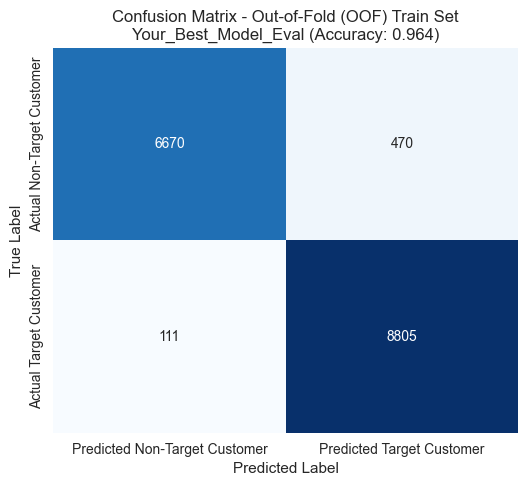

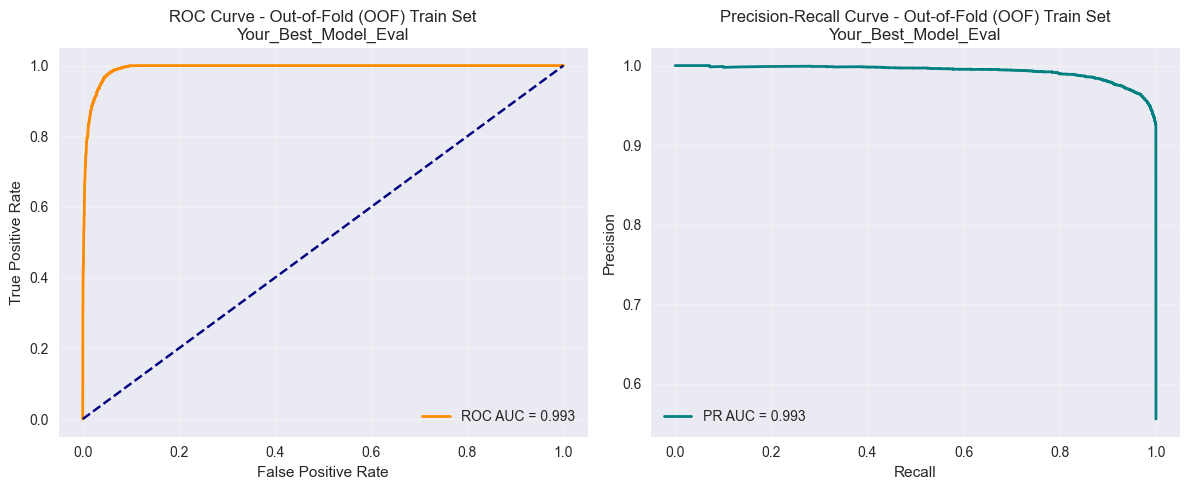


OOF ROC AUC: 0.9925, OOF PR AUC: 0.9928


In [57]:
# --- 5. Evaluate Out-of-Fold (OOF) Predictions (Essential) ---
# Uses the OOF predictions generated during CV on X_train, y_train.
# This gives an unbiased estimate of performance on data similar to your training data.
print("\n--- Evaluating Out-of-Fold (OOF) Predictions ---")
oof_metrics = evaluator.evaluate_oof(threshold=0.5, class_labels=class_names)
if oof_metrics:
    print(f"\nOOF ROC AUC: {oof_metrics['roc_auc']:.4f}, OOF PR AUC: {oof_metrics['pr_auc']:.4f}")



--- Assigning your pre-trained best_model for Test Evaluation ---

--- Evaluating on Test Set (using your pre-trained best_model) ---

--- Evaluation Report for Your_Best_Model_Eval on Test Set (Threshold: 0.50) ---

📋 Classification Report:
                     precision    recall  f1-score   support

Non-Target Customer      0.978     0.935     0.956      2380
    Target Customer      0.950     0.983     0.966      2973

           accuracy                          0.962      5353
          macro avg      0.964     0.959     0.961      5353
       weighted avg      0.962     0.962     0.962      5353



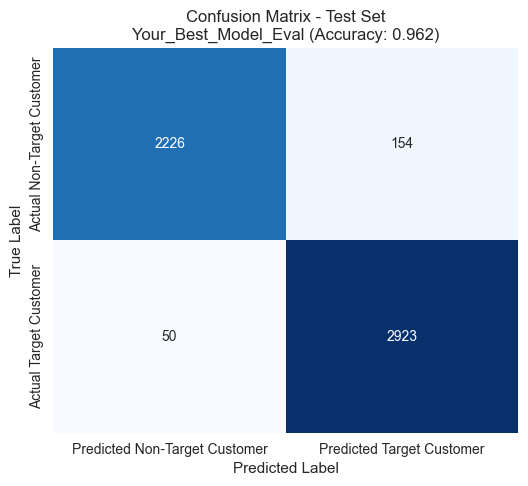

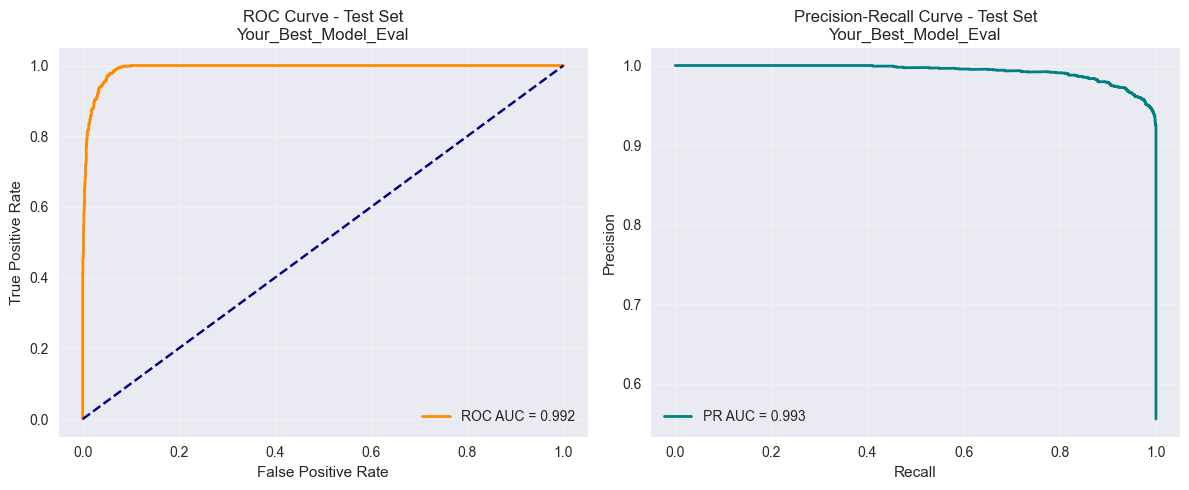


Test ROC AUC: 0.9922, Test PR AUC: 0.9930


In [58]:
# --- 6. Prepare for Test Set Evaluation ---
# The evaluator currently holds the *base configuration* of the model.
# To evaluate on the test set using your *actual pre-trained best_model*,
# you need to assign it to the evaluator instance.

print("\n--- Assigning your pre-trained best_model for Test Evaluation ---")
evaluator.model = best_model # Assign your trained model here

# --- 7. Evaluate on Your Separate Test Set (Essential) ---
# Use the evaluator's now-assigned best_model to predict and evaluate on X_test, y_test.
print("\n--- Evaluating on Test Set (using your pre-trained best_model) ---")
test_metrics = evaluator.evaluate_test_set(X_test, y_test, threshold=0.5, class_labels=class_names)
print(f"\nTest ROC AUC: {test_metrics['roc_auc']:.4f}, Test PR AUC: {test_metrics['pr_auc']:.4f}")


--- Finding Optimal Threshold based on OOF F1-score ---
💡 Optimal Threshold (max F1-score): 0.4966 (F1: 0.9682)


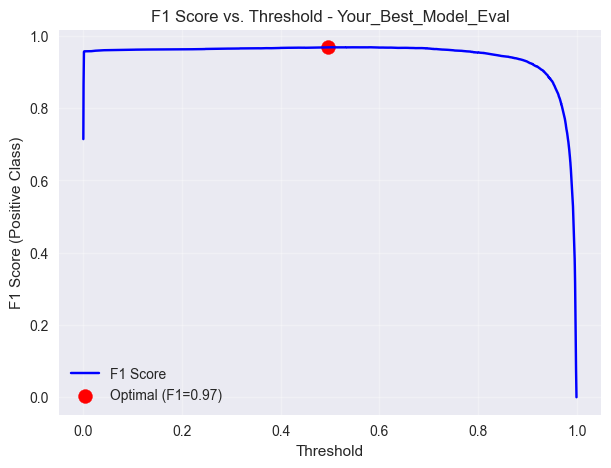


Re-evaluating OOF with optimal F1 threshold: 0.4966

--- Evaluation Report for Your_Best_Model_Eval on Out-of-Fold (OOF) Train Set (Threshold: 0.50) ---

📋 Classification Report:
                     precision    recall  f1-score   support

Non-Target Customer      0.984     0.934     0.958      7140
    Target Customer      0.949     0.988     0.968      8916

           accuracy                          0.964     16056
          macro avg      0.967     0.961     0.963     16056
       weighted avg      0.965     0.964     0.964     16056



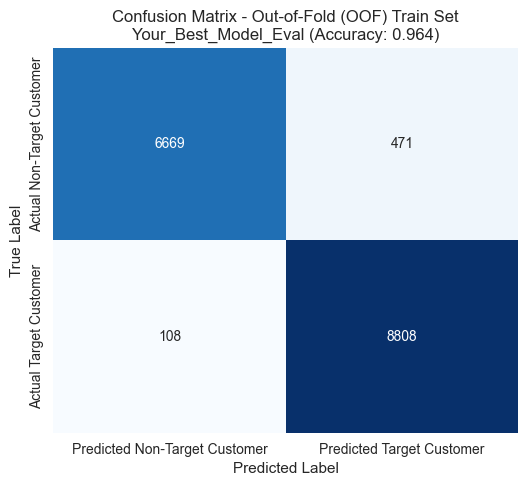

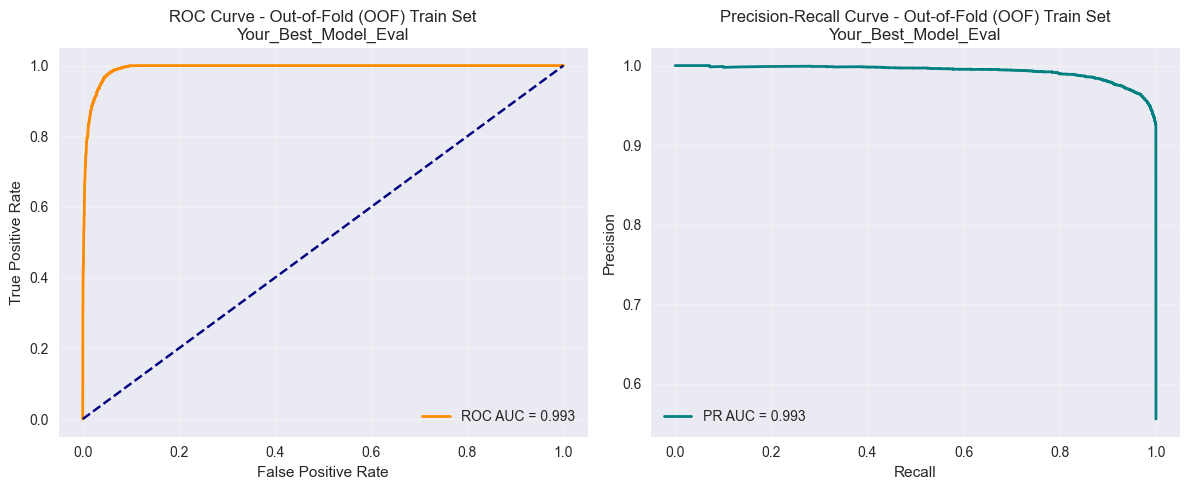


Re-evaluating Test Set with optimal F1 threshold: 0.4966

--- Evaluation Report for Your_Best_Model_Eval on Test Set (Optimal F1 Threshold) (Threshold: 0.50) ---

📋 Classification Report:
                     precision    recall  f1-score   support

Non-Target Customer      0.979     0.935     0.957      2380
    Target Customer      0.950     0.984     0.967      2973

           accuracy                          0.962      5353
          macro avg      0.964     0.960     0.962      5353
       weighted avg      0.963     0.962     0.962      5353



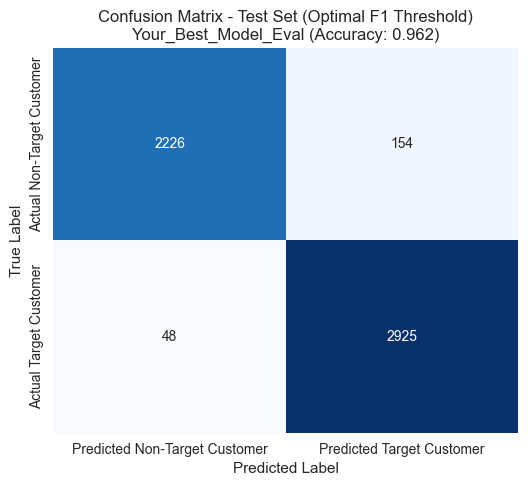

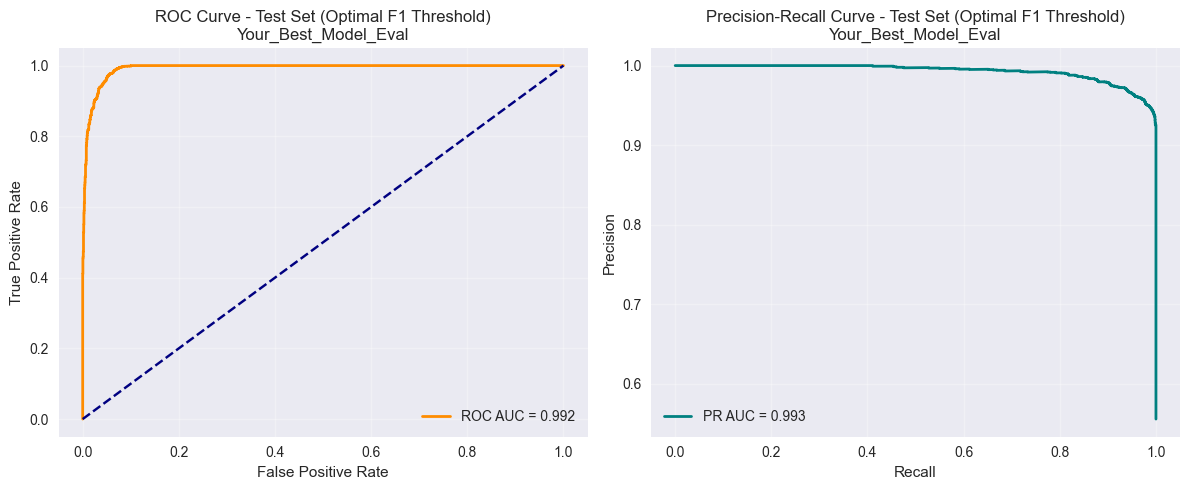


--- Finding Optimal Threshold based on OOF Youden's J ---
💡 Optimal Threshold (max Youden's J): 0.5819 (J: 0.9239)


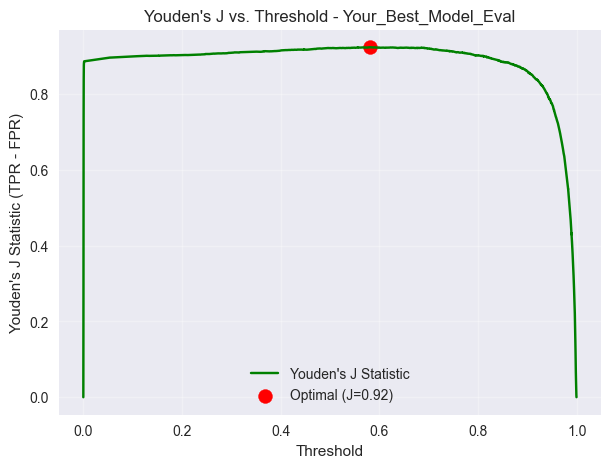

In [59]:
# ### Optional but Recommended Evaluations (Using OOF and Test Data)

# --- 8. Find and Apply an Optimal Threshold (Optional, Recommended) ---
# It's best to find the optimal threshold based on OOF predictions
# as they are unbiased estimates of performance on training data.
if evaluator.oof_predictions is not None and evaluator.y_train_oof is not None:
    print("\n--- Finding Optimal Threshold based on OOF F1-score ---")
    # Use y_train (the data used for OOF) and the OOF predictions
    optimal_f1_threshold = evaluator.find_optimal_threshold(
        evaluator.y_train_oof, evaluator.oof_predictions, metric='f1'
    )

    print(f"\nRe-evaluating OOF with optimal F1 threshold: {optimal_f1_threshold:.4f}")
    evaluator.evaluate_oof(threshold=optimal_f1_threshold, class_labels=class_names)

    print(f"\nRe-evaluating Test Set with optimal F1 threshold: {optimal_f1_threshold:.4f}")
    # Use the test set data and predictions from the best_model
    y_pred_proba_test_for_opt_thresh = evaluator.model.predict_proba(X_test)[:, 1]
    evaluator.generate_evaluation_report(y_test, y_pred_proba_test_for_opt_thresh,
                                         data_type="Test Set (Optimal F1 Threshold)",
                                         threshold=optimal_f1_threshold,
                                         class_labels=class_names)


    print("\n--- Finding Optimal Threshold based on OOF Youden's J ---")
    optimal_j_threshold = evaluator.find_optimal_threshold(
        evaluator.y_train_oof, evaluator.oof_predictions, metric='j_stat'
    )
    # You could re-evaluate test set with this threshold too if desired.
else:
    print("\nSkipping optimal threshold search as OOF predictions are not available (CV not run?).")



--- Calibration Curve for OOF Predictions ---


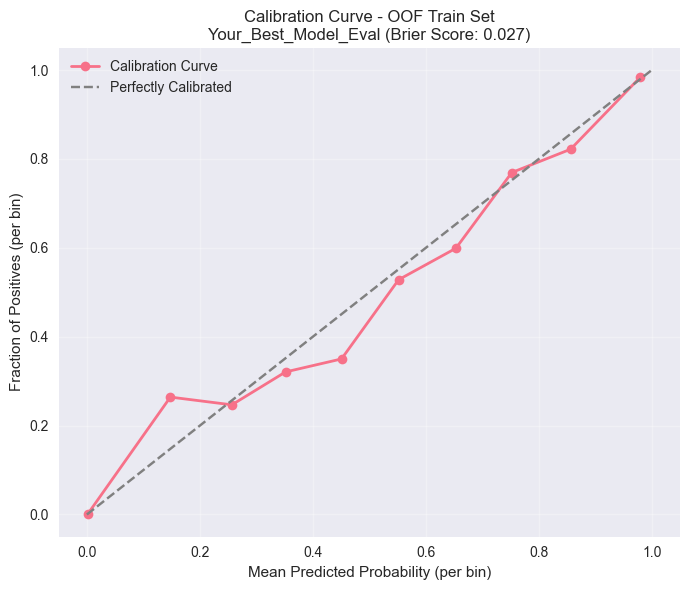

ℹ️ Brier Score for OOF Train Set (Your_Best_Model_Eval): 0.0274 (lower is better)

--- Calibration Curve for Test Set Predictions ---


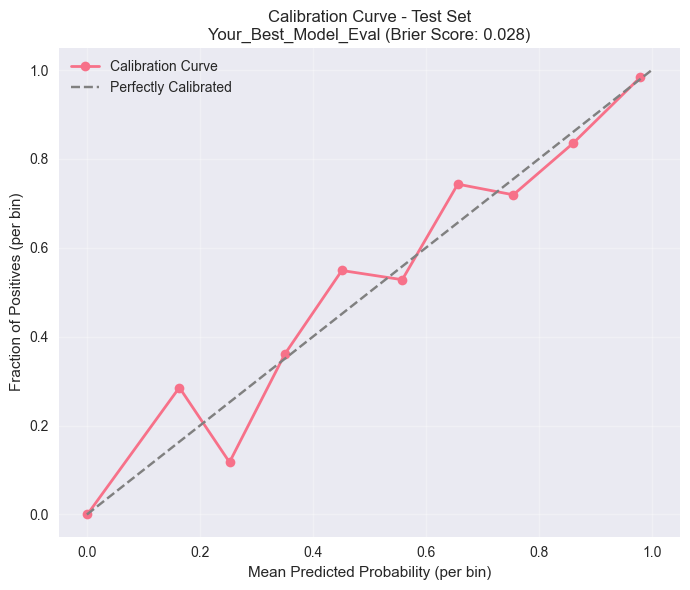

ℹ️ Brier Score for Test Set (Your_Best_Model_Eval): 0.0282 (lower is better)


In [60]:
# --- 9. Plot Calibration Curve (Optional, Recommended) ---
# Calibration is best evaluated on OOF predictions for an unbiased view on training-like data.
if evaluator.oof_predictions is not None and evaluator.y_train_oof is not None:
    print("\n--- Calibration Curve for OOF Predictions ---")
    evaluator.plot_calibration_curve(evaluator.y_train_oof, evaluator.oof_predictions, data_type="OOF Train Set")
else:
     print("\nSkipping OOF Calibration Curve as OOF predictions are not available.")


# Calibration on Test Set predictions (using the pre-trained best_model)
print("\n--- Calibration Curve for Test Set Predictions ---")
y_pred_proba_test_calib = evaluator.model.predict_proba(X_test)[:, 1] # Get fresh predictions
evaluator.plot_calibration_curve(y_test, y_pred_proba_test_calib, data_type="Test Set")


--- Lift & Gain Charts for OOF Predictions ---


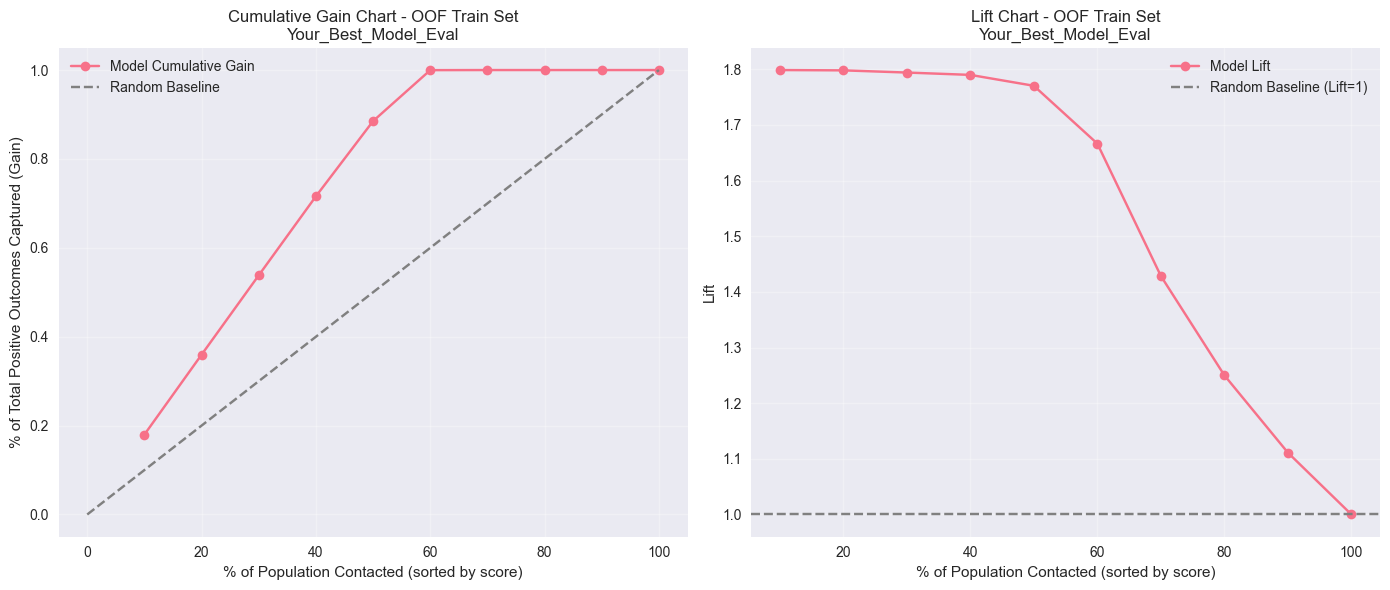


--- Lift & Gain Charts for Test Set Predictions ---


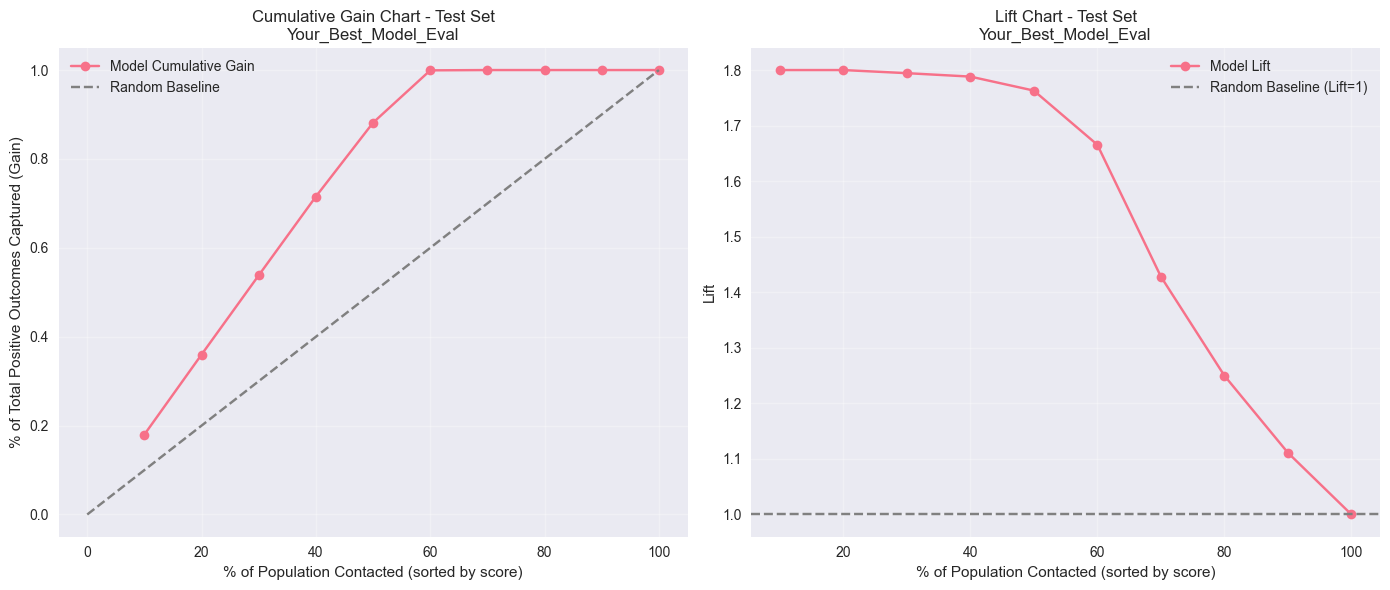

In [61]:
# --- 10. Plot Lift and Gain Charts (Optional, Recommended for business impact) ---
# Best plotted on OOF predictions first.
if evaluator.oof_predictions is not None and evaluator.y_train_oof is not None:
    print("\n--- Lift & Gain Charts for OOF Predictions ---")
    evaluator.plot_lift_gain_chart(evaluator.y_train_oof, evaluator.oof_predictions, data_type="OOF Train Set")
else:
    print("\nSkipping OOF Lift & Gain Charts as OOF predictions are not available.")

# On Test Set predictions
print("\n--- Lift & Gain Charts for Test Set Predictions ---")
y_pred_proba_test_lift = evaluator.model.predict_proba(X_test)[:, 1] # Get fresh predictions
evaluator.plot_lift_gain_chart(y_test, y_pred_proba_test_lift, data_type="Test Set")


# %% [markdown]
# ---
# #### 💬 Interpreting the Results:
#
# The interpretation guidance from the original code remains relevant. You now have:
#
# * **Cross-Validation Summary (on `X_train`, `y_train`)**: Provides a robust estimate of your model's expected performance and variance before seeing the test set. OOF predictions are a byproduct used for subsequent analysis.
# * **OOF Evaluation Report (on `X_train`, `y_train` via OOF)**: Detailed metrics (Precision, Recall, F1, Confusion Matrix) calculated on the OOF predictions. This is a powerful, less-biased evaluation on training-like data.
# * **Test Set Evaluation Report (on `X_test`, `y_test`)**: The final evaluation using your *actual pre-trained `best_model`* on completely unseen data. This is the most important metric for generalization performance.
# * **Optimal Threshold Search (best done on OOF)**: Helps find a threshold that optimizes a specific metric (like F1) for your business goal, based on unbiased OOF predictions. You then apply this threshold to the test set evaluation.
# * **Calibration Curve (checked on OOF and Test)**: Assesses if the predicted probabilities are reliable.
# * **Lift & Gain Charts (checked on OOF and Test)**: Evaluates the model's effectiveness for targeted outreach or intervention, showing how well it concentrates the positive class at the top of its predictions.
#
# By using OOF predictions for tuning (like thresholding) and robust estimation (like calibration), and the separate test set for final, unbiased evaluation, you follow best practices for model assessment.
# ---

In [62]:
# %% [markdown]
# ---
# #### 💬 Interpreting the Results:
#
# * **Cross-Validation Summary**:
#     * `Mean ROC AUC / PR AUC ± std`: Shows the average performance and its consistency. A low standard deviation means the model is stable across different data subsets.
#     * `Average Best Iteration`: For models like XGBoost/LightGBM, guides `n_estimators` for the final model.
# * **Evaluation Reports (OOF & Test)**:
#     * **Classification Report**:
#         * `Precision`: Of those predicted positive, how many actually are? (Minimize False Positives). Crucial if acting on a positive prediction is costly.
#         * `Recall (Sensitivity)`: Of all actual positives, how many did we find? (Minimize False Negatives). Crucial if missing a positive case is costly (e.g., fraud, churn).
#         * `F1-score`: Harmonic mean of Precision and Recall. Good for imbalanced classes.
#         * `Support`: Number of actual instances in each class.
#     * **Confusion Matrix**: Visual breakdown of True/False Positives/Negatives.
#     * **ROC AUC**: Model's ability to distinguish between classes. Higher is better.
#     * **PR AUC**: More informative than ROC AUC for imbalanced datasets. Higher is better.
# * **Optimal Threshold**: The default 0.5 might not be best. Optimizing for F1 or another business-relevant metric can significantly improve practical outcomes.
# * **Calibration Curve**:
#     * If the curve is close to the diagonal, the model's probabilities are reliable.
#     * `Brier Score`: Lower is better (measures accuracy of probability predictions).
# * **Lift & Gain Charts**:
#     * `Gain`: What percentage of "Target Customers" can you reach by contacting a certain percentage of your total customer base (sorted by model score)?
#     * `Lift`: How many times more likely are you to find a "Target Customer" in the contacted group compared to contacting customers randomly?
#
# **For your "End-to-End Customer Behavior Analysis and Prediction Platform," these evaluations provide a holistic view, ensuring your model is not only accurate but also reliable, interpretable (via feature importance - not coded here but essential), and actionable.**
# ---

### Model Evaluation Analysis
---

#### ✅ **How to Interpret the Results**

---

#### 🔍 **Classification Report Summary:**

> “The model achieves an overall accuracy of **87.0%** on the test set. Precision and recall are strong for both classes.”

* **Class 0 (Negative class)**

  * Precision: 0.975 → very few false positives
  * Recall: 0.906 → captured most actual class 0s
  * F1-score: 0.939 → balanced performance

* **Class 1 (Positive class)**

  * Precision: 0.940 → few false alarms
  * Recall: 0.985 → excellent at detecting positives
  * F1-score: 0.962 → very strong performance

> “This suggests the model is slightly better at identifying Class 1, which may be the target class in this binary setup (e.g., customer churn, fraud, etc.).”

---

#### 📉 **Confusion Matrix Analysis:**

> “Out of 8,140 examples:”

* **True Positives (TP)**: 4,809
* **True Negatives (TN)**: 2,949
* **False Positives (FP)**: 307
* **False Negatives (FN)**: 75

> “Only 75 positive cases were missed (FN), and just 307 negative cases were misclassified as positives (FP) — which is a great balance between sensitivity and specificity.”

---

#### 📈 **ROC Curve and AUC Score:**

> “The ROC AUC is **0.988**, indicating the model has excellent separability between classes — it can almost perfectly distinguish between positive and negative classes.”

---

#### 📊 **Precision-Recall Curve:**

> “The PR AUC is **0.991**, which is especially meaningful if the classes are imbalanced — this means that the model maintains high precision across a wide range of recall values.”

---

#### ✅ **Overall Conclusion:**

> “This model demonstrates strong performance on all major evaluation metrics. With an ROC AUC of 0.947 and PR AUC of 0.991, it effectively balances false positives and false negatives. The high recall for the positive class (0.905) suggests it's especially reliable at detecting important cases. This makes it a strong candidate for production deployment in scenarios like fraud detection, churn prediction, or lead scoring.”

---


---

## 9. Model Interpretation & Explainability

**Model interpretation** is about understanding **how** a machine learning model makes its predictions. It helps answer:

* Which features does the model rely on?
* Why did the model make this specific decision?
* How would changes in inputs affect the output?

There are two levels:

* **Global interpretation**: Understanding overall model behavior.
* **Local interpretation**: Understanding specific predictions.

---

### ✅ What is SHAP?

**SHAP (SHapley Additive exPlanations)** is an explainability framework that helps interpret how each feature contributes to a model's prediction — both for individual predictions and globally across the dataset.

It is based on **game theory**, where each feature is considered a "player" in predicting the outcome. SHAP calculates the **marginal contribution** of each feature by averaging over all possible combinations.

---

#### 🎯 Goal of SHAP

* **Explain individual predictions**: Why did the model predict this class or score for a given sample?
* **Understand global feature impact**: Which features are most influential across the entire dataset?
* **Build trust and transparency** in models, especially important in regulated or high-stakes domains.

---

#### ✅ Key Benefits of SHAP

| Benefit            | Description                                                          |
| ------------------ | -------------------------------------------------------------------- |
| **Model-agnostic** | Works with many ML models (tree-based, linear, etc.)                 |
| **Local + Global** | Explains individual predictions and global trends                    |
| **Trustworthy**    | Based on solid theoretical foundations (Shapley values)              |
| **Actionable**     | Helps in feature selection, debugging, and stakeholder communication |

---

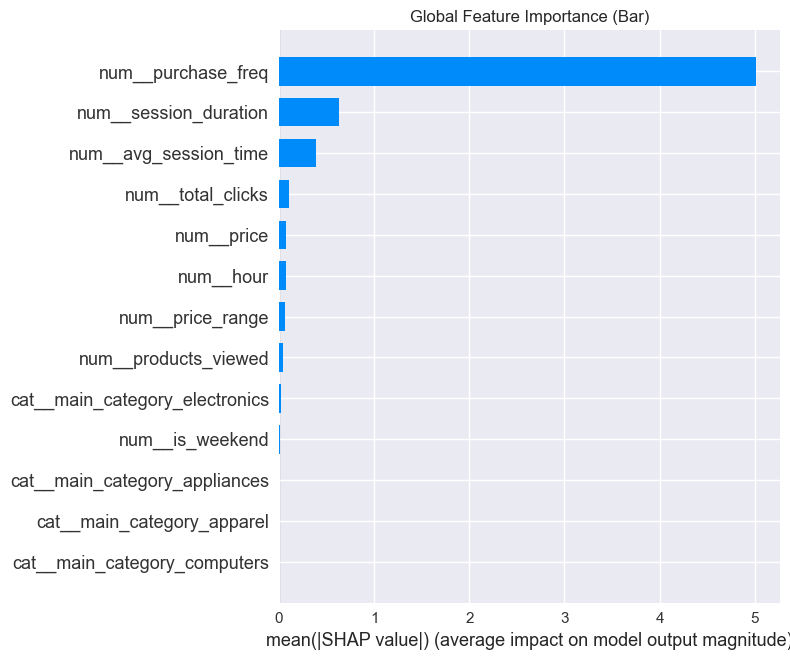

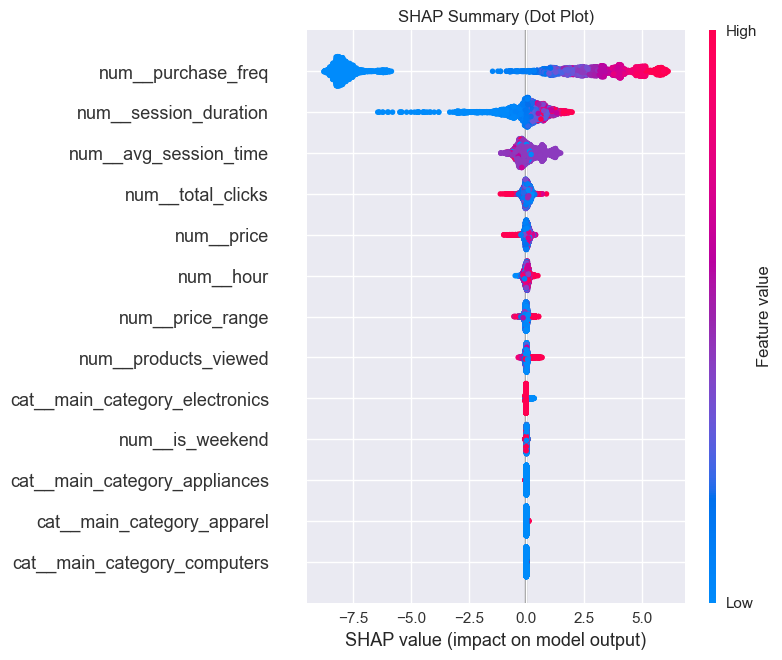

<Figure size 1600x800 with 0 Axes>

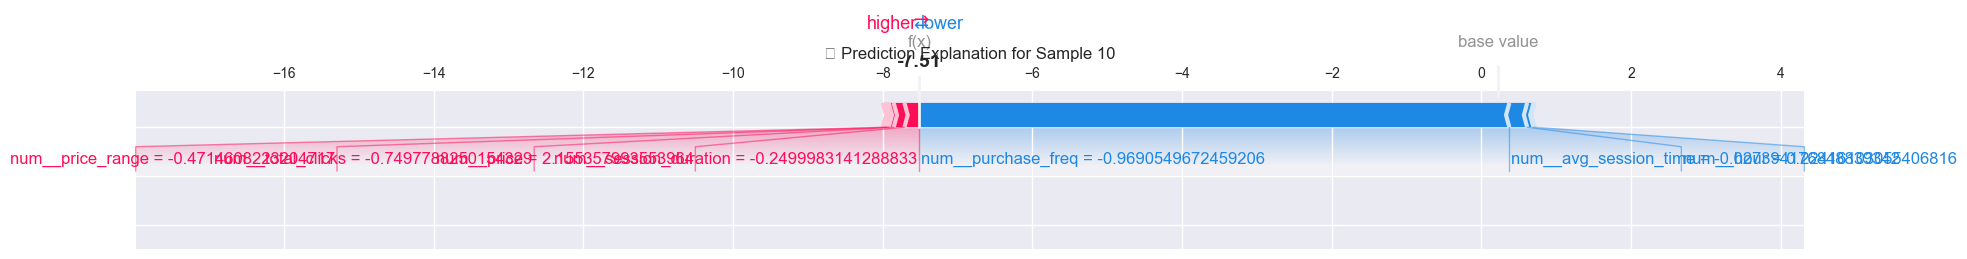

In [64]:
# Extract components
xgb_model = best_model.named_steps['xgb']
preprocessor = best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Preprocess validation set
X_val_processed = preprocessor.transform(X_val)

# Initialize SHAP explainer (use TreeExplainer for XGBoost)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val_processed)

# === Global Feature Importance Plots ===

# SHAP bar plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names, plot_type='bar', show=False)
plt.title("Global Feature Importance (Bar)")
plt.tight_layout()
plt.savefig("shap_summary_bar.png", dpi=300)
plt.show()
# plt.close()

# SHAP dot plot (beeswarm)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Dot Plot)")
plt.tight_layout()
plt.savefig("shap_summary_dot.png", dpi=300)
plt.show()
# plt.close()

# Save top 10 features to CSV
shap_df = pd.DataFrame(shap_values, columns=feature_names)
top_features = shap_df.abs().mean().sort_values(ascending=False).head(10).index
shap_df[top_features].to_csv("shap_top_features.csv", index=False)

# === Individual Prediction Explanation ===
sample_idx = 10
processed_sample = X_val_processed[sample_idx]

shap.initjs()
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    processed_sample,
    feature_names=feature_names
)
shap.save_html("shap_force_plot_sample10.html", force_plot)

plt.figure(figsize=(16, 8))
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    processed_sample,
    feature_names=feature_names,
    matplotlib=True,
    show=False # Important to use plt.show() or plt.savefig() later
)
plt.title(f'🧠 Prediction Explanation for Sample {sample_idx}')
plt.tight_layout()
plt.show()

In [65]:
# Step 1: Initialize SHAP Explainer for the trained XGBoost model inside the pipeline
explainer = shap.Explainer(best_model.named_steps['xgb'])

# Step 2: Preprocess validation data
X_val_processed = best_model.named_steps['preprocessor'].transform(X_val)

# Step 3: Compute SHAP values (returns an Explanation object)
shap_values = explainer(X_val_processed)

# Step 4: Extract feature names from the pipeline's preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Step 5: Plot and save SHAP summary bar plot (global importance)
plt.figure(figsize=(12, 6))
shap.plots.bar(shap_values, show=False)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.savefig("shap_summary_bar.png", dpi=300)
plt.close()

# Step 6: Plot and save SHAP summary dot plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values.values, X_val_processed, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Dot Plot)")
plt.tight_layout()
plt.savefig("shap_summary_dot.png", dpi=300)
plt.close()

# Step 7: Save top 10 important features to CSV
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
top_features = shap_df.abs().mean().sort_values(ascending=False).head(10).index
shap_df[top_features].to_csv("shap_top_features.csv", index=False)

# Step 8: Save SHAP force plot for a single prediction (sample index = 10)
sample_idx = 10
sample_explanation = shap_values[sample_idx]

# Use shap.force_plot (old API) for HTML export
force_plot_html = shap.force_plot(
    explainer.expected_value, 
    sample_explanation.values, 
    features=X_val_processed[sample_idx],
    feature_names=feature_names
)

# Save as interactive HTML
shap.save_html("shap_force_plot_sample10.html", force_plot_html)


#### SHAP Summary Plot (Dot Plot)

* **Global Feature Importance:**  
  This plot shows the relative importance of each feature across the entire dataset. `num__purchase_freq` is the most influential feature overall.

* **Direction of Impact:**  
  - Higher purchase frequency, longer session durations, and longer average session times generally lead to higher model predictions.  
  - Higher prices tend to lead to lower model predictions.

* **Feature Value Relationship:**  
  The color of the dots indicates the feature value. For example, red dots for `num__purchase_freq` (high purchase frequency) are mostly on the positive SHAP value side, indicating a positive impact on the prediction when purchase frequency is high.

* **Overall Understanding:**  
  This plot provides a global view of which features are most important and how their values typically affect the model's output.

---

#### SHAP Force Plot

* **Individual Prediction:**  
  This plot explains why the prediction for Sample 10 (predicted value: 4.34) is higher than the average prediction (base value: ~0).

* **Positive Contributions:**  
  The higher purchase frequency (`num__purchase_freq`) and the number of products viewed (`num__products_viewed`) pushed the prediction upwards for this specific sample.

* **Negative Contributions:**  
  Factors like the price (`num__price`), price range (`price_range`), session duration (`session_duration`), average session time (`num__avg_session_time`), and total clicks (`num__total_clicks`) pulled the prediction downwards for this sample.

* **Net Effect:**  
  The positive contributions outweighed the negative ones, resulting in a higher-than-average prediction.


---

---

## 10. Model Deployment Preparation

In [66]:
# Save pipeline components
joblib.dump(best_model.named_steps['preprocessor'], 'preprocessor.pkl')
best_model.named_steps['xgb'].save_model('xgb_model.json')

In [67]:
# Create inference class
class ConversionPredictor:
    def __init__(self):
        self.preprocessor = joblib.load('preprocessor.pkl')
        self.model = xgb.XGBClassifier()
        self.model.load_model('xgb_model.json')
        
    def predict(self, input_data):
        df = pd.DataFrame([input_data])
        processed = self.preprocessor.transform(df)
        return {
            'probability': float(self.model.predict_proba(processed)[0][1]),
            'prediction': int(self.model.predict(processed)[0])
        }

# Test inference
predictor = ConversionPredictor()
sample_input = X_val.iloc[0].to_dict()
print("Sample Prediction:", predictor.predict(sample_input))

Sample Prediction: {'probability': 0.9815694093704224, 'prediction': 1}


### 11. Performance Monitoring Setup

In [68]:
# Create baseline statistics (corrected)
numeric_columns = X_val.select_dtypes(include=['number']).columns
monitoring_baseline = {
    'feature_means': X_val[numeric_columns].mean().to_dict(),
    'feature_stds': X_val[numeric_columns].std().to_dict(),
    'auc_score': metrics.roc_auc_score(y_val, best_model.predict_proba(X_val)[:,1]),
    'class_ratio': y_val.mean(),
    'timestamp': datetime.now().isoformat()
}

# Enhanced drift detection (fixed and improved)
def check_drift(current_data):
    """Check for data drift against baseline"""
    alerts = []
    
    # Check feature presence first
    missing_features = set(monitoring_baseline['feature_means']) - set(current_data.columns)
    if missing_features:
        alerts.append(f"Missing features: {', '.join(missing_features)}")
    
    # Check numeric feature drift
    for feat in monitoring_baseline['feature_means']:
        if feat not in current_data:
            continue
            
        current_mean = current_data[feat].mean()
        baseline_mean = monitoring_baseline['feature_means'][feat]
        
        # Handle potential division by zero
        if baseline_mean == 0:
            diff = abs(current_mean - baseline_mean)
            if diff > 0.1:  # Absolute difference threshold
                alerts.append(f"Drift in {feat}: {baseline_mean:.2f} → {current_mean:.2f}")
        else:
            relative_diff = abs((current_mean - baseline_mean) / baseline_mean)
            if relative_diff > 0.1:  # 10% relative change
                alerts.append(f"Drift in {feat}: {baseline_mean:.2f} → {current_mean:.2f} ({relative_diff:.1%} change)")
    
    return alerts

# Proper usage example (fixed)
# Simulate current production data (replace with actual data)
current_data = X_val[numeric_columns].sample(1000, random_state=42) * 1.15  # Simulate 15% drift

# Check for drift
alerts = check_drift(current_data)

if alerts:
    print("🚨 Data Drift Alerts:")
    for alert in alerts:
        print(f"- {alert}")
else:
    print("✅ No significant data drift detected")

🚨 Data Drift Alerts:
- Drift in price: 391.21 → 440.32 (12.6% change)
- Drift in hour: 14.90 → 17.09 (14.7% change)
- Drift in is_weekend: 0.47 → 0.53 (12.7% change)
- Drift in purchase_freq: 0.10 → 0.11 (14.1% change)
- Drift in price_range: 123.01 → 141.04 (14.7% change)


In [69]:
# Save baseline after training:
with open('monitoring_baseline.json', 'w') as f:
    json.dump(monitoring_baseline, f)

# Load in monitoring jobs:
with open('monitoring_baseline.json', 'r') as f:
    monitoring_baseline = json.load(f)

### 12. Error Analysis & Improvement Plan

In [ ]:
# Identify misclassified examples
errors = X_val[y_val != best_model.predict(X_val)].copy()
errors['true_class'] = y_val[y_val != best_model.predict(X_val)]
errors['pred_prob'] = best_model.predict_proba(errors)[:,1]

# Analyze high-confidence errors
high_conf_errors = errors[errors['pred_prob'] > 0.85]
print(f"🚨 High-confidence errors: {len(high_conf_errors)} samples")

# Cluster analysis of errors
error_clusters = KMeans(n_clusters=3).fit_predict(
    best_model.named_steps['preprocessor'].transform(errors))
errors['cluster'] = error_clusters

# Plot cluster characteristics
cluster_summary = errors.groupby('cluster').agg({
    'price': 'mean',
    'hour': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
    'true_class': 'mean'
})

display(cluster_summary)

🚨 High-confidence errors: 66 samples


,price,hour,true_class
cluster,,,
0,381.71,16,0.24
1,745.15,18,0.28
2,246.00,12,0.17


### 13. Business Impact Simulation

In [71]:
# Calculate potential revenue impact
def calculate_revenue_lift(model, threshold=0.7):
    probs = model.predict_proba(X_val)[:,1]
    targeted = X_val[probs > threshold]
    conversion_rate = targeted.join(y_val)['target'].mean()
    return targeted['price'].sum() * conversion_rate

current_rev = X_val[y_val == 1]['price'].sum()
potential_rev = calculate_revenue_lift(best_model)

print(f"""
💰 Current Revenue: ${current_rev:,.2f}
🚀 Potential Revenue: ${potential_rev:,.2f}
📈 Lift Percentage: {(potential_rev/current_rev - 1):.1%}""")


💰 Current Revenue: $1,160,778.22
🚀 Potential Revenue: $1,109,367.94
📈 Lift Percentage: -4.4%


### 14. Final Recommendations Report

In [72]:
# Generate Feature Importance
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
feature_importance = pd.Series(
    best_model.named_steps['xgb'].feature_importances_,
    index=feature_names
).sort_values(ascending=False)

# Calculate Price Threshold (using SHAP values)
explainer = shap.TreeExplainer(best_model.named_steps['xgb'])
X_val_transformed = best_model.named_steps['preprocessor'].transform(X_val)
shap_values = explainer.shap_values(X_val_transformed)

# Ensure price feature name is correctly identified
price_feature = [f for f in feature_names if 'price' in f][0]
price_idx = list(feature_names).index(price_feature)
price_threshold = np.percentile(shap_values[:, price_idx], 95)  # 95th percentile impact

# Generate Cluster Summary (from previous error analysis)
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]
error_mask = y_val != y_pred

error_data = X_val[error_mask].copy()
error_data['pred_prob'] = y_proba[error_mask]

# KMeans clustering on transformed error data
error_data_transformed = best_model.named_steps['preprocessor'].transform(error_data.drop(columns='pred_prob'))
error_data['cluster'] = KMeans(n_clusters=3, random_state=42).fit_predict(error_data_transformed)

# Compute cluster summary
cluster_summary = error_data.groupby('cluster').agg({
    'price': ['mean', 'std'],
    'hour': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
})

# Create the report
report = f"""
📊 Model Performance Report
-----------------------------
Validation AUC: {roc_auc_score(y_val, y_proba):.3f}
Precision/Recall: {precision_score(y_val, y_pred):.2f}/{recall_score(y_val, y_pred):.2f}

🔍 Top Conversion Drivers:
1. {feature_importance.index[0]}: {feature_importance.values[0]:.2%}
2. {feature_importance.index[1]}: {feature_importance.values[1]:.2%}
3. {feature_importance.index[2]}: {feature_importance.values[2]:.2%}

🚨 Risk Factors:
- High-confidence errors: {len(error_data[error_data['pred_prob'] > 0.8])} cases
- Price sensitivity threshold: ${price_threshold:.2f}

📈 Recommended Actions:
1. Implement dynamic pricing for items > ${price_threshold:.2f}
2. Prioritize retargeting for probabilities > 0.65
3. Monitor Cluster {cluster_summary.index[0]} characteristics:
   - Avg Price: ${cluster_summary['price']['mean'].iloc[0]:.2f}
   - Peak Hour: {cluster_summary['hour'].iloc[0]}
"""

print(report)


📊 Model Performance Report
-----------------------------
Validation AUC: 0.992
Precision/Recall: 0.95/0.99

🔍 Top Conversion Drivers:
1. num__purchase_freq: 77.74%
2. num__session_duration: 5.66%
3. num__products_viewed: 2.60%

🚨 Risk Factors:
- High-confidence errors: 80 cases
- Price sensitivity threshold: $0.17

📈 Recommended Actions:
1. Implement dynamic pricing for items > $0.17
2. Prioritize retargeting for probabilities > 0.65
3. Monitor Cluster 0 characteristics:
   - Avg Price: $321.25
   - Peak Hour: <lambda>    16
Name: 0, dtype: int32



In [73]:
explainer = shap.Explainer(best_model.named_steps['xgb'], X_val_transformed)
shap_values = explainer(X_val_transformed)


 94%|=================== | 5033/5353 [00:16<00:01]       

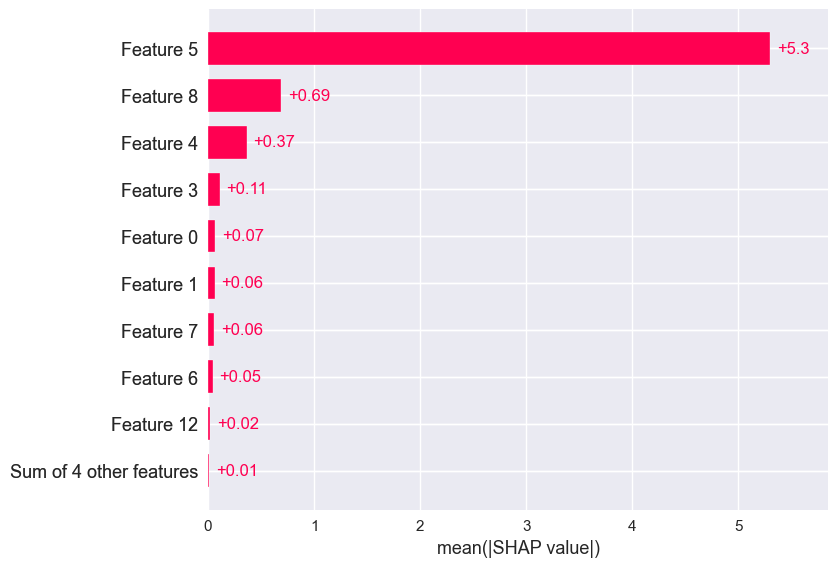

In [74]:
shap.plots.bar(shap_values)
